# Código para o método PROMETHEE-Score

iniciarei importando algumas bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from PROMETHEE import PROMETHEE_2

In [2]:
dados = pd.read_excel("dados.xlsx", index_col=0)
dados = dados.dropna(axis=0)
dados.loc["Hong Kong"]

Property Rights           93.3
Judical Effectiveness     75.3
Government Integrity      83.8
Tax Burden                93.1
Gov't Spending            90.3
Fiscal Health            100.0
Business Freedom          96.4
Labor Freedom             89.2
Monetary Freedom          86.4
Trade Freedom             95.0
Investment Freedom        90.0
Financial Freedom         90.0
Name: Hong Kong, dtype: float64

In [3]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [4]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

net_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1]

In [5]:
pd.DataFrame(net_flows, index=dados.index).loc["Hong Kong"]

0    0.875253
Name: Hong Kong, dtype: float64

### SMAA

- Vamos agora rodar o PROMETHEE no mesmo conjunto de dados, porém, usaremos variáveis aleatórias.

In [6]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [7]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= dados.index)
Sigma_Mu_df.columns


Index(['Sigma', 'Mu'], dtype='object')

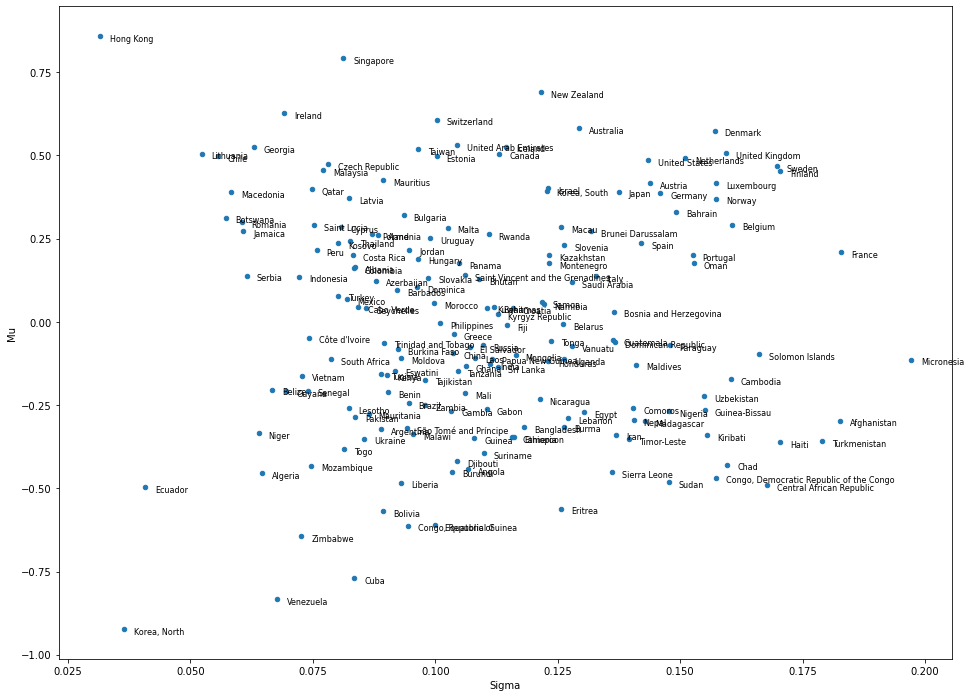

In [8]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [9]:
# Possívei ideia de usar KMeans antes da otimização
"""
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(Sigma_Mu_df)
kmeans.labels_

Sigma_Mu_df.assign(Category = kmeans.labels_)

Sigma_Mu_df_clusters = Sigma_Mu_df.assign(Category = kmeans.labels_)
Sigma_Mu_df_clusters
"""

'\nfrom sklearn.cluster import KMeans\nkmeans = KMeans(n_clusters=3, random_state=0).fit(Sigma_Mu_df)\nkmeans.labels_\n\nSigma_Mu_df.assign(Category = kmeans.labels_)\n\nSigma_Mu_df_clusters = Sigma_Mu_df.assign(Category = kmeans.labels_)\nSigma_Mu_df_clusters\n'

### PKFs 

In the cell below, I'll obtain the PKFs for the Sigma-Mu plot 

In [9]:
df =Sigma_Mu_df.copy()

In [10]:
df

,Sigma,Mu
Afghanistan,0.182544,-0.296802
Albania,0.083635,0.164883
Algeria,0.064668,-0.454777
Angola,0.106600,-0.441867
Argentina,0.088875,-0.321900
...,...,...
Vanuatu,0.127849,-0.071910
Venezuela,0.067758,-0.831970
Vietnam,0.072821,-0.161785
Zambia,0.097923,-0.249086


In [12]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1



PKF_1: ['Hong Kong']
PKF_2: ['Ecuador', 'Georgia', 'Ireland', 'Korea, North ', 'Lithuania', 'Singapore']
PKF_3: ['Chile', 'New Zealand', 'Switzerland', 'Taiwan ']
PKF_4: ['Australia', 'Botswana', 'Czech Republic', 'Estonia', 'Macedonia', 'Malaysia', 'Qatar', 'United Arab Emirates']
PKF_5: ['Canada', 'Denmark', 'Iceland', 'Latvia', 'Mauritius', 'Romania']
PKF_6: ['Bulgaria', 'Israel', 'Jamaica', 'Korea, South', 'Netherlands', 'Saint Lucia', 'United Kingdom', 'United States']
PKF_7: ['Austria', 'Cyprus', 'Japan', 'Kosovo', 'Peru', 'Serbia', 'Sweden']
PKF_8: ['Belize', 'Finland', 'Germany', 'Indonesia', 'Luxembourg', 'Macau', 'Malta', 'Niger', 'Poland', 'Thailand']
PKF_9: ['Algeria', 'Armenia', 'Bahrain', 'Brunei Darussalam', 'Costa Rica', "Côte d'Ivoire", 'Guyana', 'Norway', 'Rwanda', 'Turkey', 'Vietnam']
PKF_10: ['Albania', 'Belgium', 'Colombia', 'Jordan', 'Mexico', 'Senegal', 'South Africa', 'Uruguay', 'Venezuela', 'Zimbabwe']
PKF_11: ['Azerbaijan', 'Cabo Verde', 'Hungary', 'Kazakhstan

### Otimização

O Score das alternativas é obtido através de um modelo de otimização linear.

In [34]:
from PROMETHEE import optimize_PROM2_original, optimize_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        Fr_list = [] # list of alternatives within frontier fr or within a less preferred one
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[Fr_list]) # get alternatives within frontier fr or a less preferred one
        
        
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        


alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 1, fronteira 23: resolvido.
alternative 1, fronteira 24: resolvido.
alternative 1, fronteira 25: resolvido.
alternati

In [35]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Korea, North "]

Global Efficiency     1.384675
Position             88.000000
Name: Korea, North , dtype: float64

In [36]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Korea, North "]

Global Efficiency    -18.195791
Position             180.000000
Name: Korea, North , dtype: float64

# DADOS TCC TUANY

In [37]:
dados = pd.read_excel("dados_TCC.xlsx", index_col=0)
dados = dados.dropna(axis=0)
dados.loc["Brazil"]

Economic Quality                    47.953634
Education                           59.270767
Enterprise Conditions               47.827354
Governance                          51.796293
Health                              72.023236
Infrastructure and Market Access    54.907069
Investment Environment              56.183145
Living Conditions                   80.422237
Natural Environment                 67.827058
Personal Freedom                    66.955451
Safety and Security                 61.247103
Social Capital                      48.436590
Name: Brazil, dtype: float64

In [38]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [39]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

net_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1]

In [40]:
pd.DataFrame(net_flows, index=dados.index).loc["Brazil"]

0    0.117535
Name: Brazil, dtype: float64

In [41]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [42]:
mu_net = np.mean(Net_Flows, axis=1)
sigma_net = np.std(Net_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_net,"Mu": mu_net}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma', 'Mu'], dtype='object')

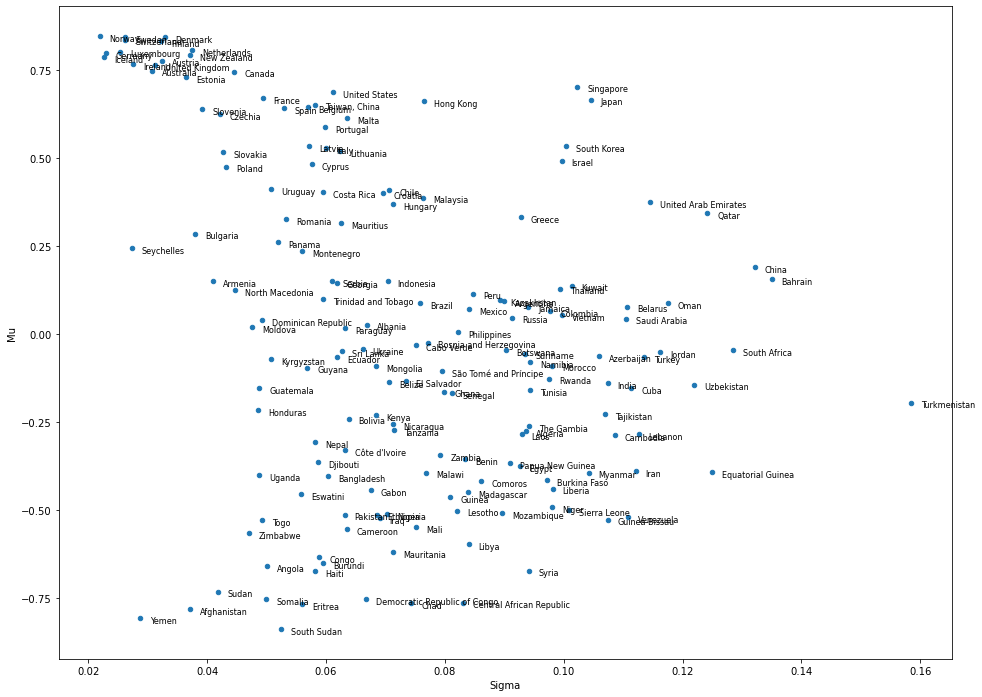

In [43]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [22]:
df =Sigma_Mu_df.copy()
PKF=[] # Receber a fronteira PKF

count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Germany', 'Iceland', 'Norway', 'Sweden']
PKF_2: ['Austria', 'Denmark', 'Switzerland']
PKF_3: ['Finland', 'Ireland', 'Luxembourg']
PKF_4: ['Netherlands', 'New Zealand', 'United Kingdom']
PKF_5: ['Canada', 'Seychelles']
PKF_6: ['Australia']
PKF_7: ['Estonia']
PKF_8: ['Armenia', 'Bulgaria', 'France', 'Hong Kong', 'Japan', 'Singapore', 'Spain']
PKF_9: ['Belgium', 'Czechia', 'Panama', 'Slovakia', 'Slovenia', 'Sudan', 'Taiwan, China', 'Yemen']
PKF_10: ['Guatemala', 'Malta', 'Montenegro', 'North Macedonia', 'Poland', 'Portugal', 'United States']
PKF_11: ['Afghanistan', 'Bangladesh', 'Honduras', 'Italy', 'Latvia', 'Mauritius', 'Moldova', 'Romania', 'Somalia', 'South Korea', 'Uruguay', 'Zimbabwe']
PKF_12: ['Cyprus', 'Dominican Republic', 'Eritrea', 'Guyana', 'Kyrgyzstan', 'Lithuania']
PKF_13: ['Albania', 'Costa Rica', 'Croatia', 'Georgia', 'Israel', 'Paraguay', 'South Sudan', 'Uganda']
PKF_14: ['Angola', 'Bolivia', 'Chile', 'Congo', "Côte d'Ivoire", 'Ecuador', 'Eswatini', 'Hungary', 'M

In [23]:
from PROMETHEE import optimize_PROM2_original, optimize_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr or a less preferred one
        
        M, resultado = optimize_PROM2_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 1, fronteira 23: resolvido.
alternative 1, fronteira 24: resolvido.
alternative 1, fronteira 25: resolvido.
alternati

alternative 8, fronteira 19: resolvido.
alternative 8, fronteira 20: resolvido.
alternative 8, fronteira 21: resolvido.
alternative 8, fronteira 22: resolvido.
alternative 8, fronteira 23: resolvido.
alternative 8, fronteira 24: resolvido.
alternative 8, fronteira 25: resolvido.
alternative 8, fronteira 26: resolvido.
alternative 8, fronteira 27: resolvido.
alternative 9, fronteira 1: resolvido.
alternative 9, fronteira 2: resolvido.
alternative 9, fronteira 3: resolvido.
alternative 9, fronteira 4: resolvido.
alternative 9, fronteira 5: resolvido.
alternative 9, fronteira 6: resolvido.
alternative 9, fronteira 7: resolvido.
alternative 9, fronteira 8: resolvido.
alternative 9, fronteira 9: resolvido.
alternative 9, fronteira 10: resolvido.
alternative 9, fronteira 11: resolvido.
alternative 9, fronteira 12: resolvido.
alternative 9, fronteira 13: resolvido.
alternative 9, fronteira 14: resolvido.
alternative 9, fronteira 15: resolvido.
alternative 9, fronteira 16: resolvido.
alternati

alternative 16, fronteira 6: resolvido.
alternative 16, fronteira 7: resolvido.
alternative 16, fronteira 8: resolvido.
alternative 16, fronteira 9: resolvido.
alternative 16, fronteira 10: resolvido.
alternative 16, fronteira 11: resolvido.
alternative 16, fronteira 12: resolvido.
alternative 16, fronteira 13: resolvido.
alternative 16, fronteira 14: resolvido.
alternative 16, fronteira 15: resolvido.
alternative 16, fronteira 16: resolvido.
alternative 16, fronteira 17: resolvido.
alternative 16, fronteira 18: resolvido.
alternative 16, fronteira 19: resolvido.
alternative 16, fronteira 20: resolvido.
alternative 16, fronteira 21: resolvido.
alternative 16, fronteira 22: resolvido.
alternative 16, fronteira 23: resolvido.
alternative 16, fronteira 24: resolvido.
alternative 16, fronteira 25: resolvido.
alternative 16, fronteira 26: resolvido.
alternative 16, fronteira 27: resolvido.
alternative 17, fronteira 1: resolvido.
alternative 17, fronteira 2: resolvido.
alternative 17, fronte

alternative 23, fronteira 19: resolvido.
alternative 23, fronteira 20: resolvido.
alternative 23, fronteira 21: resolvido.
alternative 23, fronteira 22: resolvido.
alternative 23, fronteira 23: resolvido.
alternative 23, fronteira 24: resolvido.
alternative 23, fronteira 25: resolvido.
alternative 23, fronteira 26: resolvido.
alternative 23, fronteira 27: resolvido.
alternative 24, fronteira 1: resolvido.
alternative 24, fronteira 2: resolvido.
alternative 24, fronteira 3: resolvido.
alternative 24, fronteira 4: resolvido.
alternative 24, fronteira 5: resolvido.
alternative 24, fronteira 6: resolvido.
alternative 24, fronteira 7: resolvido.
alternative 24, fronteira 8: resolvido.
alternative 24, fronteira 9: resolvido.
alternative 24, fronteira 10: resolvido.
alternative 24, fronteira 11: resolvido.
alternative 24, fronteira 12: resolvido.
alternative 24, fronteira 13: resolvido.
alternative 24, fronteira 14: resolvido.
alternative 24, fronteira 15: resolvido.
alternative 24, fronteira

alternative 31, fronteira 5: resolvido.
alternative 31, fronteira 6: resolvido.
alternative 31, fronteira 7: resolvido.
alternative 31, fronteira 8: resolvido.
alternative 31, fronteira 9: resolvido.
alternative 31, fronteira 10: resolvido.
alternative 31, fronteira 11: resolvido.
alternative 31, fronteira 12: resolvido.
alternative 31, fronteira 13: resolvido.
alternative 31, fronteira 14: resolvido.
alternative 31, fronteira 15: resolvido.
alternative 31, fronteira 16: resolvido.
alternative 31, fronteira 17: resolvido.
alternative 31, fronteira 18: resolvido.
alternative 31, fronteira 19: resolvido.
alternative 31, fronteira 20: resolvido.
alternative 31, fronteira 21: resolvido.
alternative 31, fronteira 22: resolvido.
alternative 31, fronteira 23: resolvido.
alternative 31, fronteira 24: resolvido.
alternative 31, fronteira 25: resolvido.
alternative 31, fronteira 26: resolvido.
alternative 31, fronteira 27: resolvido.
alternative 32, fronteira 1: resolvido.
alternative 32, fronte

alternative 38, fronteira 18: resolvido.
alternative 38, fronteira 19: resolvido.
alternative 38, fronteira 20: resolvido.
alternative 38, fronteira 21: resolvido.
alternative 38, fronteira 22: resolvido.
alternative 38, fronteira 23: resolvido.
alternative 38, fronteira 24: resolvido.
alternative 38, fronteira 25: resolvido.
alternative 38, fronteira 26: resolvido.
alternative 38, fronteira 27: resolvido.
alternative 39, fronteira 1: resolvido.
alternative 39, fronteira 2: resolvido.
alternative 39, fronteira 3: resolvido.
alternative 39, fronteira 4: resolvido.
alternative 39, fronteira 5: resolvido.
alternative 39, fronteira 6: resolvido.
alternative 39, fronteira 7: resolvido.
alternative 39, fronteira 8: resolvido.
alternative 39, fronteira 9: resolvido.
alternative 39, fronteira 10: resolvido.
alternative 39, fronteira 11: resolvido.
alternative 39, fronteira 12: resolvido.
alternative 39, fronteira 13: resolvido.
alternative 39, fronteira 14: resolvido.
alternative 39, fronteira

alternative 46, fronteira 4: resolvido.
alternative 46, fronteira 5: resolvido.
alternative 46, fronteira 6: resolvido.
alternative 46, fronteira 7: resolvido.
alternative 46, fronteira 8: resolvido.
alternative 46, fronteira 9: resolvido.
alternative 46, fronteira 10: resolvido.
alternative 46, fronteira 11: resolvido.
alternative 46, fronteira 12: resolvido.
alternative 46, fronteira 13: resolvido.
alternative 46, fronteira 14: resolvido.
alternative 46, fronteira 15: resolvido.
alternative 46, fronteira 16: resolvido.
alternative 46, fronteira 17: resolvido.
alternative 46, fronteira 18: resolvido.
alternative 46, fronteira 19: resolvido.
alternative 46, fronteira 20: resolvido.
alternative 46, fronteira 21: resolvido.
alternative 46, fronteira 22: resolvido.
alternative 46, fronteira 23: resolvido.
alternative 46, fronteira 24: resolvido.
alternative 46, fronteira 25: resolvido.
alternative 46, fronteira 26: resolvido.
alternative 46, fronteira 27: resolvido.
alternative 47, fronte

alternative 53, fronteira 17: resolvido.
alternative 53, fronteira 18: resolvido.
alternative 53, fronteira 19: resolvido.
alternative 53, fronteira 20: resolvido.
alternative 53, fronteira 21: resolvido.
alternative 53, fronteira 22: resolvido.
alternative 53, fronteira 23: resolvido.
alternative 53, fronteira 24: resolvido.
alternative 53, fronteira 25: resolvido.
alternative 53, fronteira 26: resolvido.
alternative 53, fronteira 27: resolvido.
alternative 54, fronteira 1: resolvido.
alternative 54, fronteira 2: resolvido.
alternative 54, fronteira 3: resolvido.
alternative 54, fronteira 4: resolvido.
alternative 54, fronteira 5: resolvido.
alternative 54, fronteira 6: resolvido.
alternative 54, fronteira 7: resolvido.
alternative 54, fronteira 8: resolvido.
alternative 54, fronteira 9: resolvido.
alternative 54, fronteira 10: resolvido.
alternative 54, fronteira 11: resolvido.
alternative 54, fronteira 12: resolvido.
alternative 54, fronteira 13: resolvido.
alternative 54, fronteira

alternative 61, fronteira 3: resolvido.
alternative 61, fronteira 4: resolvido.
alternative 61, fronteira 5: resolvido.
alternative 61, fronteira 6: resolvido.
alternative 61, fronteira 7: resolvido.
alternative 61, fronteira 8: resolvido.
alternative 61, fronteira 9: resolvido.
alternative 61, fronteira 10: resolvido.
alternative 61, fronteira 11: resolvido.
alternative 61, fronteira 12: resolvido.
alternative 61, fronteira 13: resolvido.
alternative 61, fronteira 14: resolvido.
alternative 61, fronteira 15: resolvido.
alternative 61, fronteira 16: resolvido.
alternative 61, fronteira 17: resolvido.
alternative 61, fronteira 18: resolvido.
alternative 61, fronteira 19: resolvido.
alternative 61, fronteira 20: resolvido.
alternative 61, fronteira 21: resolvido.
alternative 61, fronteira 22: resolvido.
alternative 61, fronteira 23: resolvido.
alternative 61, fronteira 24: resolvido.
alternative 61, fronteira 25: resolvido.
alternative 61, fronteira 26: resolvido.
alternative 61, frontei

alternative 68, fronteira 16: resolvido.
alternative 68, fronteira 17: resolvido.
alternative 68, fronteira 18: resolvido.
alternative 68, fronteira 19: resolvido.
alternative 68, fronteira 20: resolvido.
alternative 68, fronteira 21: resolvido.
alternative 68, fronteira 22: resolvido.
alternative 68, fronteira 23: resolvido.
alternative 68, fronteira 24: resolvido.
alternative 68, fronteira 25: resolvido.
alternative 68, fronteira 26: resolvido.
alternative 68, fronteira 27: resolvido.
alternative 69, fronteira 1: resolvido.
alternative 69, fronteira 2: resolvido.
alternative 69, fronteira 3: resolvido.
alternative 69, fronteira 4: resolvido.
alternative 69, fronteira 5: resolvido.
alternative 69, fronteira 6: resolvido.
alternative 69, fronteira 7: resolvido.
alternative 69, fronteira 8: resolvido.
alternative 69, fronteira 9: resolvido.
alternative 69, fronteira 10: resolvido.
alternative 69, fronteira 11: resolvido.
alternative 69, fronteira 12: resolvido.
alternative 69, fronteira

alternative 76, fronteira 2: resolvido.
alternative 76, fronteira 3: resolvido.
alternative 76, fronteira 4: resolvido.
alternative 76, fronteira 5: resolvido.
alternative 76, fronteira 6: resolvido.
alternative 76, fronteira 7: resolvido.
alternative 76, fronteira 8: resolvido.
alternative 76, fronteira 9: resolvido.
alternative 76, fronteira 10: resolvido.
alternative 76, fronteira 11: resolvido.
alternative 76, fronteira 12: resolvido.
alternative 76, fronteira 13: resolvido.
alternative 76, fronteira 14: resolvido.
alternative 76, fronteira 15: resolvido.
alternative 76, fronteira 16: resolvido.
alternative 76, fronteira 17: resolvido.
alternative 76, fronteira 18: resolvido.
alternative 76, fronteira 19: resolvido.
alternative 76, fronteira 20: resolvido.
alternative 76, fronteira 21: resolvido.
alternative 76, fronteira 22: resolvido.
alternative 76, fronteira 23: resolvido.
alternative 76, fronteira 24: resolvido.
alternative 76, fronteira 25: resolvido.
alternative 76, fronteir

alternative 83, fronteira 15: resolvido.
alternative 83, fronteira 16: resolvido.
alternative 83, fronteira 17: resolvido.
alternative 83, fronteira 18: resolvido.
alternative 83, fronteira 19: resolvido.
alternative 83, fronteira 20: resolvido.
alternative 83, fronteira 21: resolvido.
alternative 83, fronteira 22: resolvido.
alternative 83, fronteira 23: resolvido.
alternative 83, fronteira 24: resolvido.
alternative 83, fronteira 25: resolvido.
alternative 83, fronteira 26: resolvido.
alternative 83, fronteira 27: resolvido.
alternative 84, fronteira 1: resolvido.
alternative 84, fronteira 2: resolvido.
alternative 84, fronteira 3: resolvido.
alternative 84, fronteira 4: resolvido.
alternative 84, fronteira 5: resolvido.
alternative 84, fronteira 6: resolvido.
alternative 84, fronteira 7: resolvido.
alternative 84, fronteira 8: resolvido.
alternative 84, fronteira 9: resolvido.
alternative 84, fronteira 10: resolvido.
alternative 84, fronteira 11: resolvido.
alternative 84, fronteira

alternative 91, fronteira 1: resolvido.
alternative 91, fronteira 2: resolvido.
alternative 91, fronteira 3: resolvido.
alternative 91, fronteira 4: resolvido.
alternative 91, fronteira 5: resolvido.
alternative 91, fronteira 6: resolvido.
alternative 91, fronteira 7: resolvido.
alternative 91, fronteira 8: resolvido.
alternative 91, fronteira 9: resolvido.
alternative 91, fronteira 10: resolvido.
alternative 91, fronteira 11: resolvido.
alternative 91, fronteira 12: resolvido.
alternative 91, fronteira 13: resolvido.
alternative 91, fronteira 14: resolvido.
alternative 91, fronteira 15: resolvido.
alternative 91, fronteira 16: resolvido.
alternative 91, fronteira 17: resolvido.
alternative 91, fronteira 18: resolvido.
alternative 91, fronteira 19: resolvido.
alternative 91, fronteira 20: resolvido.
alternative 91, fronteira 21: resolvido.
alternative 91, fronteira 22: resolvido.
alternative 91, fronteira 23: resolvido.
alternative 91, fronteira 24: resolvido.
alternative 91, fronteira

alternative 98, fronteira 14: resolvido.
alternative 98, fronteira 15: resolvido.
alternative 98, fronteira 16: resolvido.
alternative 98, fronteira 17: resolvido.
alternative 98, fronteira 18: resolvido.
alternative 98, fronteira 19: resolvido.
alternative 98, fronteira 20: resolvido.
alternative 98, fronteira 21: resolvido.
alternative 98, fronteira 22: resolvido.
alternative 98, fronteira 23: resolvido.
alternative 98, fronteira 24: resolvido.
alternative 98, fronteira 25: resolvido.
alternative 98, fronteira 26: resolvido.
alternative 98, fronteira 27: resolvido.
alternative 99, fronteira 1: resolvido.
alternative 99, fronteira 2: resolvido.
alternative 99, fronteira 3: resolvido.
alternative 99, fronteira 4: resolvido.
alternative 99, fronteira 5: resolvido.
alternative 99, fronteira 6: resolvido.
alternative 99, fronteira 7: resolvido.
alternative 99, fronteira 8: resolvido.
alternative 99, fronteira 9: resolvido.
alternative 99, fronteira 10: resolvido.
alternative 99, fronteira

alternative 105, fronteira 23: resolvido.
alternative 105, fronteira 24: resolvido.
alternative 105, fronteira 25: resolvido.
alternative 105, fronteira 26: resolvido.
alternative 105, fronteira 27: resolvido.
alternative 106, fronteira 1: resolvido.
alternative 106, fronteira 2: resolvido.
alternative 106, fronteira 3: resolvido.
alternative 106, fronteira 4: resolvido.
alternative 106, fronteira 5: resolvido.
alternative 106, fronteira 6: resolvido.
alternative 106, fronteira 7: resolvido.
alternative 106, fronteira 8: resolvido.
alternative 106, fronteira 9: resolvido.
alternative 106, fronteira 10: resolvido.
alternative 106, fronteira 11: resolvido.
alternative 106, fronteira 12: resolvido.
alternative 106, fronteira 13: resolvido.
alternative 106, fronteira 14: resolvido.
alternative 106, fronteira 15: resolvido.
alternative 106, fronteira 16: resolvido.
alternative 106, fronteira 17: resolvido.
alternative 106, fronteira 18: resolvido.
alternative 106, fronteira 19: resolvido.
a

alternative 113, fronteira 4: resolvido.
alternative 113, fronteira 5: resolvido.
alternative 113, fronteira 6: resolvido.
alternative 113, fronteira 7: resolvido.
alternative 113, fronteira 8: resolvido.
alternative 113, fronteira 9: resolvido.
alternative 113, fronteira 10: resolvido.
alternative 113, fronteira 11: resolvido.
alternative 113, fronteira 12: resolvido.
alternative 113, fronteira 13: resolvido.
alternative 113, fronteira 14: resolvido.
alternative 113, fronteira 15: resolvido.
alternative 113, fronteira 16: resolvido.
alternative 113, fronteira 17: resolvido.
alternative 113, fronteira 18: resolvido.
alternative 113, fronteira 19: resolvido.
alternative 113, fronteira 20: resolvido.
alternative 113, fronteira 21: resolvido.
alternative 113, fronteira 22: resolvido.
alternative 113, fronteira 23: resolvido.
alternative 113, fronteira 24: resolvido.
alternative 113, fronteira 25: resolvido.
alternative 113, fronteira 26: resolvido.
alternative 113, fronteira 27: resolvido

alternative 120, fronteira 12: resolvido.
alternative 120, fronteira 13: resolvido.
alternative 120, fronteira 14: resolvido.
alternative 120, fronteira 15: resolvido.
alternative 120, fronteira 16: resolvido.
alternative 120, fronteira 17: resolvido.
alternative 120, fronteira 18: resolvido.
alternative 120, fronteira 19: resolvido.
alternative 120, fronteira 20: resolvido.
alternative 120, fronteira 21: resolvido.
alternative 120, fronteira 22: resolvido.
alternative 120, fronteira 23: resolvido.
alternative 120, fronteira 24: resolvido.
alternative 120, fronteira 25: resolvido.
alternative 120, fronteira 26: resolvido.
alternative 120, fronteira 27: resolvido.
alternative 121, fronteira 1: resolvido.
alternative 121, fronteira 2: resolvido.
alternative 121, fronteira 3: resolvido.
alternative 121, fronteira 4: resolvido.
alternative 121, fronteira 5: resolvido.
alternative 121, fronteira 6: resolvido.
alternative 121, fronteira 7: resolvido.
alternative 121, fronteira 8: resolvido.


alternative 127, fronteira 20: resolvido.
alternative 127, fronteira 21: resolvido.
alternative 127, fronteira 22: resolvido.
alternative 127, fronteira 23: resolvido.
alternative 127, fronteira 24: resolvido.
alternative 127, fronteira 25: resolvido.
alternative 127, fronteira 26: resolvido.
alternative 127, fronteira 27: resolvido.
alternative 128, fronteira 1: resolvido.
alternative 128, fronteira 2: resolvido.
alternative 128, fronteira 3: resolvido.
alternative 128, fronteira 4: resolvido.
alternative 128, fronteira 5: resolvido.
alternative 128, fronteira 6: resolvido.
alternative 128, fronteira 7: resolvido.
alternative 128, fronteira 8: resolvido.
alternative 128, fronteira 9: resolvido.
alternative 128, fronteira 10: resolvido.
alternative 128, fronteira 11: resolvido.
alternative 128, fronteira 12: resolvido.
alternative 128, fronteira 13: resolvido.
alternative 128, fronteira 14: resolvido.
alternative 128, fronteira 15: resolvido.
alternative 128, fronteira 16: resolvido.
a

alternative 135, fronteira 1: resolvido.
alternative 135, fronteira 2: resolvido.
alternative 135, fronteira 3: resolvido.
alternative 135, fronteira 4: resolvido.
alternative 135, fronteira 5: resolvido.
alternative 135, fronteira 6: resolvido.
alternative 135, fronteira 7: resolvido.
alternative 135, fronteira 8: resolvido.
alternative 135, fronteira 9: resolvido.
alternative 135, fronteira 10: resolvido.
alternative 135, fronteira 11: resolvido.
alternative 135, fronteira 12: resolvido.
alternative 135, fronteira 13: resolvido.
alternative 135, fronteira 14: resolvido.
alternative 135, fronteira 15: resolvido.
alternative 135, fronteira 16: resolvido.
alternative 135, fronteira 17: resolvido.
alternative 135, fronteira 18: resolvido.
alternative 135, fronteira 19: resolvido.
alternative 135, fronteira 20: resolvido.
alternative 135, fronteira 21: resolvido.
alternative 135, fronteira 22: resolvido.
alternative 135, fronteira 23: resolvido.
alternative 135, fronteira 24: resolvido.
a

alternative 142, fronteira 9: resolvido.
alternative 142, fronteira 10: resolvido.
alternative 142, fronteira 11: resolvido.
alternative 142, fronteira 12: resolvido.
alternative 142, fronteira 13: resolvido.
alternative 142, fronteira 14: resolvido.
alternative 142, fronteira 15: resolvido.
alternative 142, fronteira 16: resolvido.
alternative 142, fronteira 17: resolvido.
alternative 142, fronteira 18: resolvido.
alternative 142, fronteira 19: resolvido.
alternative 142, fronteira 20: resolvido.
alternative 142, fronteira 21: resolvido.
alternative 142, fronteira 22: resolvido.
alternative 142, fronteira 23: resolvido.
alternative 142, fronteira 24: resolvido.
alternative 142, fronteira 25: resolvido.
alternative 142, fronteira 26: resolvido.
alternative 142, fronteira 27: resolvido.
alternative 143, fronteira 1: resolvido.
alternative 143, fronteira 2: resolvido.
alternative 143, fronteira 3: resolvido.
alternative 143, fronteira 4: resolvido.
alternative 143, fronteira 5: resolvido

alternative 149, fronteira 17: resolvido.
alternative 149, fronteira 18: resolvido.
alternative 149, fronteira 19: resolvido.
alternative 149, fronteira 20: resolvido.
alternative 149, fronteira 21: resolvido.
alternative 149, fronteira 22: resolvido.
alternative 149, fronteira 23: resolvido.
alternative 149, fronteira 24: resolvido.
alternative 149, fronteira 25: resolvido.
alternative 149, fronteira 26: resolvido.
alternative 149, fronteira 27: resolvido.
alternative 150, fronteira 1: resolvido.
alternative 150, fronteira 2: resolvido.
alternative 150, fronteira 3: resolvido.
alternative 150, fronteira 4: resolvido.
alternative 150, fronteira 5: resolvido.
alternative 150, fronteira 6: resolvido.
alternative 150, fronteira 7: resolvido.
alternative 150, fronteira 8: resolvido.
alternative 150, fronteira 9: resolvido.
alternative 150, fronteira 10: resolvido.
alternative 150, fronteira 11: resolvido.
alternative 150, fronteira 12: resolvido.
alternative 150, fronteira 13: resolvido.
a

alternative 156, fronteira 25: resolvido.
alternative 156, fronteira 26: resolvido.
alternative 156, fronteira 27: resolvido.
alternative 157, fronteira 1: resolvido.
alternative 157, fronteira 2: resolvido.
alternative 157, fronteira 3: resolvido.
alternative 157, fronteira 4: resolvido.
alternative 157, fronteira 5: resolvido.
alternative 157, fronteira 6: resolvido.
alternative 157, fronteira 7: resolvido.
alternative 157, fronteira 8: resolvido.
alternative 157, fronteira 9: resolvido.
alternative 157, fronteira 10: resolvido.
alternative 157, fronteira 11: resolvido.
alternative 157, fronteira 12: resolvido.
alternative 157, fronteira 13: resolvido.
alternative 157, fronteira 14: resolvido.
alternative 157, fronteira 15: resolvido.
alternative 157, fronteira 16: resolvido.
alternative 157, fronteira 17: resolvido.
alternative 157, fronteira 18: resolvido.
alternative 157, fronteira 19: resolvido.
alternative 157, fronteira 20: resolvido.
alternative 157, fronteira 21: resolvido.
a

alternative 164, fronteira 6: resolvido.
alternative 164, fronteira 7: resolvido.
alternative 164, fronteira 8: resolvido.
alternative 164, fronteira 9: resolvido.
alternative 164, fronteira 10: resolvido.
alternative 164, fronteira 11: resolvido.
alternative 164, fronteira 12: resolvido.
alternative 164, fronteira 13: resolvido.
alternative 164, fronteira 14: resolvido.
alternative 164, fronteira 15: resolvido.
alternative 164, fronteira 16: resolvido.
alternative 164, fronteira 17: resolvido.
alternative 164, fronteira 18: resolvido.
alternative 164, fronteira 19: resolvido.
alternative 164, fronteira 20: resolvido.
alternative 164, fronteira 21: resolvido.
alternative 164, fronteira 22: resolvido.
alternative 164, fronteira 23: resolvido.
alternative 164, fronteira 24: resolvido.
alternative 164, fronteira 25: resolvido.
alternative 164, fronteira 26: resolvido.
alternative 164, fronteira 27: resolvido.
alternative 165, fronteira 1: resolvido.
alternative 165, fronteira 2: resolvido

In [24]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["South Sudan"]

Global Efficiency     0.101447
Position             88.000000
Name: South Sudan, dtype: float64

In [25]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["South Sudan"]

Global Efficiency    -21.974838
Position             167.000000
Name: South Sudan, dtype: float64

In [26]:
#PROMETHEE I PARA FLUXO POSITIVO

In [27]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [28]:
# Aplica o PROMETHEE_1 ao nosso conjunto de dados

pos_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[2]


In [29]:
pd.DataFrame(pos_flows, index=dados.index).loc["Brazil"]

0    0.32488
Name: Brazil, dtype: float64

In [30]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [31]:
mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_pos,"Mu": mu_pos}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma', 'Mu'], dtype='object')

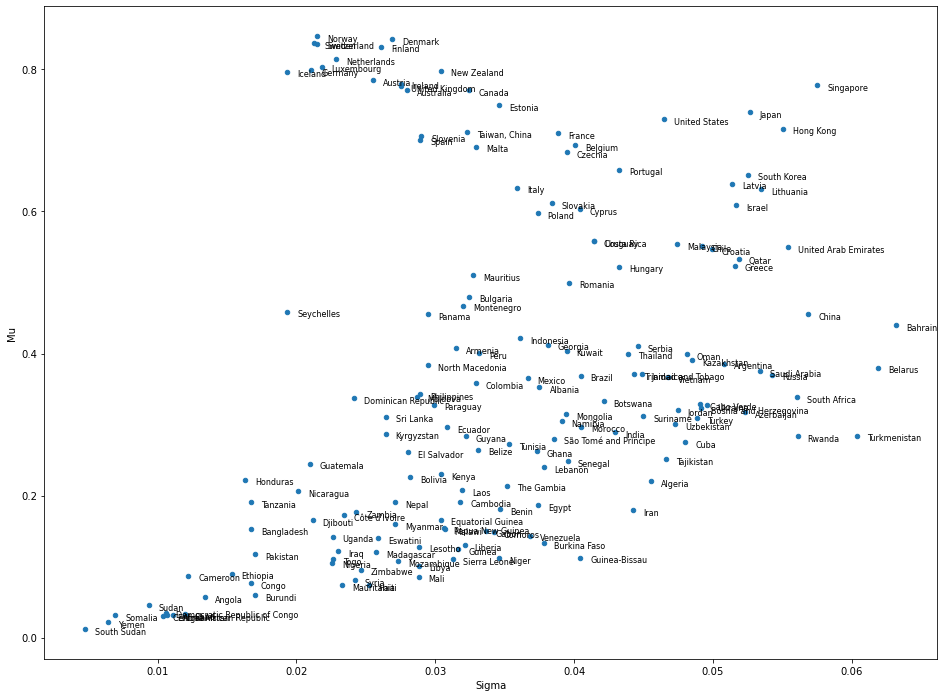

In [32]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [33]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Cameroon', 'Ethiopia', 'Germany', 'Honduras', 'Iceland', 'Norway', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Sweden', 'Yemen']
PKF_2: ['Angola', 'Central African Republic', 'Congo', 'Democratic Republic of Congo', 'Denmark', 'Guatemala', 'Nicaragua', 'Switzerland', 'Tanzania']
PKF_3: ['Afghanistan', 'Bangladesh', 'Chad', 'Djibouti', 'Eritrea', 'Finland', 'Luxembourg', 'Netherlands']
PKF_4: ['Austria', "Côte d'Ivoire", 'Dominican Republic', 'New Zealand', 'Pakistan', 'Uganda']
PKF_5: ['Burundi', 'Iraq', 'Ireland', 'Kyrgyzstan', 'Nigeria', 'Sri Lanka', 'Togo', 'United Kingdom', 'Zambia']
PKF_6: ['Australia', 'Canada', 'Eswatini', 'Madagascar', 'Mauritania', 'Myanmar', 'Nepal', 'Singapore', 'Syria', 'Zimbabwe']
PKF_7: ['El Salvador', 'Estonia', 'Haiti', 'Moldova', 'Mozambique', 'Philippines', 'Slovenia', 'Spain', 'Taiwan, China']
PKF_8: ['Bolivia', 'Bulgaria', 'France', 'Japan', 'Malta', 'Mauritius', 'Montenegro', 'North Macedonia', 'Panama', 'United States']
PKF_9: ['Arm

In [34]:
from PROMETHEE import optimize_PROM1_original_pos_flow, optimize_newconstraint_pos_flow

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr or a less preferred one
        
        M, resultado = optimize_PROM1_original_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint_pos_flow(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2

alternative 10, fronteira 19: resolvido.
alternative 10, fronteira 20: resolvido.
alternative 10, fronteira 21: resolvido.
alternative 11, fronteira 1: resolvido.
alternative 11, fronteira 2: resolvido.
alternative 11, fronteira 3: resolvido.
alternative 11, fronteira 4: resolvido.
alternative 11, fronteira 5: resolvido.
alternative 11, fronteira 6: resolvido.
alternative 11, fronteira 7: resolvido.
alternative 11, fronteira 8: resolvido.
alternative 11, fronteira 9: resolvido.
alternative 11, fronteira 10: resolvido.
alternative 11, fronteira 11: resolvido.
alternative 11, fronteira 12: resolvido.
alternative 11, fronteira 13: resolvido.
alternative 11, fronteira 14: resolvido.
alternative 11, fronteira 15: resolvido.
alternative 11, fronteira 16: resolvido.
alternative 11, fronteira 17: resolvido.
alternative 11, fronteira 18: resolvido.
alternative 11, fronteira 19: resolvido.
alternative 11, fronteira 20: resolvido.
alternative 11, fronteira 21: resolvido.
alternative 12, fronteira

alternative 20, fronteira 12: resolvido.
alternative 20, fronteira 13: resolvido.
alternative 20, fronteira 14: resolvido.
alternative 20, fronteira 15: resolvido.
alternative 20, fronteira 16: resolvido.
alternative 20, fronteira 17: resolvido.
alternative 20, fronteira 18: resolvido.
alternative 20, fronteira 19: resolvido.
alternative 20, fronteira 20: resolvido.
alternative 20, fronteira 21: resolvido.
alternative 21, fronteira 1: resolvido.
alternative 21, fronteira 2: resolvido.
alternative 21, fronteira 3: resolvido.
alternative 21, fronteira 4: resolvido.
alternative 21, fronteira 5: resolvido.
alternative 21, fronteira 6: resolvido.
alternative 21, fronteira 7: resolvido.
alternative 21, fronteira 8: resolvido.
alternative 21, fronteira 9: resolvido.
alternative 21, fronteira 10: resolvido.
alternative 21, fronteira 11: resolvido.
alternative 21, fronteira 12: resolvido.
alternative 21, fronteira 13: resolvido.
alternative 21, fronteira 14: resolvido.
alternative 21, fronteira

alternative 30, fronteira 4: resolvido.
alternative 30, fronteira 5: resolvido.
alternative 30, fronteira 6: resolvido.
alternative 30, fronteira 7: resolvido.
alternative 30, fronteira 8: resolvido.
alternative 30, fronteira 9: resolvido.
alternative 30, fronteira 10: resolvido.
alternative 30, fronteira 11: resolvido.
alternative 30, fronteira 12: resolvido.
alternative 30, fronteira 13: resolvido.
alternative 30, fronteira 14: resolvido.
alternative 30, fronteira 15: resolvido.
alternative 30, fronteira 16: resolvido.
alternative 30, fronteira 17: resolvido.
alternative 30, fronteira 18: resolvido.
alternative 30, fronteira 19: resolvido.
alternative 30, fronteira 20: resolvido.
alternative 30, fronteira 21: resolvido.
alternative 31, fronteira 1: resolvido.
alternative 31, fronteira 2: resolvido.
alternative 31, fronteira 3: resolvido.
alternative 31, fronteira 4: resolvido.
alternative 31, fronteira 5: resolvido.
alternative 31, fronteira 6: resolvido.
alternative 31, fronteira 7:

alternative 39, fronteira 17: resolvido.
alternative 39, fronteira 18: resolvido.
alternative 39, fronteira 19: resolvido.
alternative 39, fronteira 20: resolvido.
alternative 39, fronteira 21: resolvido.
alternative 40, fronteira 1: resolvido.
alternative 40, fronteira 2: resolvido.
alternative 40, fronteira 3: resolvido.
alternative 40, fronteira 4: resolvido.
alternative 40, fronteira 5: resolvido.
alternative 40, fronteira 6: resolvido.
alternative 40, fronteira 7: resolvido.
alternative 40, fronteira 8: resolvido.
alternative 40, fronteira 9: resolvido.
alternative 40, fronteira 10: resolvido.
alternative 40, fronteira 11: resolvido.
alternative 40, fronteira 12: resolvido.
alternative 40, fronteira 13: resolvido.
alternative 40, fronteira 14: resolvido.
alternative 40, fronteira 15: resolvido.
alternative 40, fronteira 16: resolvido.
alternative 40, fronteira 17: resolvido.
alternative 40, fronteira 18: resolvido.
alternative 40, fronteira 19: resolvido.
alternative 40, fronteira

alternative 49, fronteira 9: resolvido.
alternative 49, fronteira 10: resolvido.
alternative 49, fronteira 11: resolvido.
alternative 49, fronteira 12: resolvido.
alternative 49, fronteira 13: resolvido.
alternative 49, fronteira 14: resolvido.
alternative 49, fronteira 15: resolvido.
alternative 49, fronteira 16: resolvido.
alternative 49, fronteira 17: resolvido.
alternative 49, fronteira 18: resolvido.
alternative 49, fronteira 19: resolvido.
alternative 49, fronteira 20: resolvido.
alternative 49, fronteira 21: resolvido.
alternative 50, fronteira 1: resolvido.
alternative 50, fronteira 2: resolvido.
alternative 50, fronteira 3: resolvido.
alternative 50, fronteira 4: resolvido.
alternative 50, fronteira 5: resolvido.
alternative 50, fronteira 6: resolvido.
alternative 50, fronteira 7: resolvido.
alternative 50, fronteira 8: resolvido.
alternative 50, fronteira 9: resolvido.
alternative 50, fronteira 10: resolvido.
alternative 50, fronteira 11: resolvido.
alternative 50, fronteira 

alternative 59, fronteira 1: resolvido.
alternative 59, fronteira 2: resolvido.
alternative 59, fronteira 3: resolvido.
alternative 59, fronteira 4: resolvido.
alternative 59, fronteira 5: resolvido.
alternative 59, fronteira 6: resolvido.
alternative 59, fronteira 7: resolvido.
alternative 59, fronteira 8: resolvido.
alternative 59, fronteira 9: resolvido.
alternative 59, fronteira 10: resolvido.
alternative 59, fronteira 11: resolvido.
alternative 59, fronteira 12: resolvido.
alternative 59, fronteira 13: resolvido.
alternative 59, fronteira 14: resolvido.
alternative 59, fronteira 15: resolvido.
alternative 59, fronteira 16: resolvido.
alternative 59, fronteira 17: resolvido.
alternative 59, fronteira 18: resolvido.
alternative 59, fronteira 19: resolvido.
alternative 59, fronteira 20: resolvido.
alternative 59, fronteira 21: resolvido.
alternative 60, fronteira 1: resolvido.
alternative 60, fronteira 2: resolvido.
alternative 60, fronteira 3: resolvido.
alternative 60, fronteira 4:

alternative 68, fronteira 15: resolvido.
alternative 68, fronteira 16: resolvido.
alternative 68, fronteira 17: resolvido.
alternative 68, fronteira 18: resolvido.
alternative 68, fronteira 19: resolvido.
alternative 68, fronteira 20: resolvido.
alternative 68, fronteira 21: resolvido.
alternative 69, fronteira 1: resolvido.
alternative 69, fronteira 2: resolvido.
alternative 69, fronteira 3: resolvido.
alternative 69, fronteira 4: resolvido.
alternative 69, fronteira 5: resolvido.
alternative 69, fronteira 6: resolvido.
alternative 69, fronteira 7: resolvido.
alternative 69, fronteira 8: resolvido.
alternative 69, fronteira 9: resolvido.
alternative 69, fronteira 10: resolvido.
alternative 69, fronteira 11: resolvido.
alternative 69, fronteira 12: resolvido.
alternative 69, fronteira 13: resolvido.
alternative 69, fronteira 14: resolvido.
alternative 69, fronteira 15: resolvido.
alternative 69, fronteira 16: resolvido.
alternative 69, fronteira 17: resolvido.
alternative 69, fronteira

alternative 78, fronteira 7: resolvido.
alternative 78, fronteira 8: resolvido.
alternative 78, fronteira 9: resolvido.
alternative 78, fronteira 10: resolvido.
alternative 78, fronteira 11: resolvido.
alternative 78, fronteira 12: resolvido.
alternative 78, fronteira 13: resolvido.
alternative 78, fronteira 14: resolvido.
alternative 78, fronteira 15: resolvido.
alternative 78, fronteira 16: resolvido.
alternative 78, fronteira 17: resolvido.
alternative 78, fronteira 18: resolvido.
alternative 78, fronteira 19: resolvido.
alternative 78, fronteira 20: resolvido.
alternative 78, fronteira 21: resolvido.
alternative 79, fronteira 1: resolvido.
alternative 79, fronteira 2: resolvido.
alternative 79, fronteira 3: resolvido.
alternative 79, fronteira 4: resolvido.
alternative 79, fronteira 5: resolvido.
alternative 79, fronteira 6: resolvido.
alternative 79, fronteira 7: resolvido.
alternative 79, fronteira 8: resolvido.
alternative 79, fronteira 9: resolvido.
alternative 79, fronteira 10

alternative 87, fronteira 20: resolvido.
alternative 87, fronteira 21: resolvido.
alternative 88, fronteira 1: resolvido.
alternative 88, fronteira 2: resolvido.
alternative 88, fronteira 3: resolvido.
alternative 88, fronteira 4: resolvido.
alternative 88, fronteira 5: resolvido.
alternative 88, fronteira 6: resolvido.
alternative 88, fronteira 7: resolvido.
alternative 88, fronteira 8: resolvido.
alternative 88, fronteira 9: resolvido.
alternative 88, fronteira 10: resolvido.
alternative 88, fronteira 11: resolvido.
alternative 88, fronteira 12: resolvido.
alternative 88, fronteira 13: resolvido.
alternative 88, fronteira 14: resolvido.
alternative 88, fronteira 15: resolvido.
alternative 88, fronteira 16: resolvido.
alternative 88, fronteira 17: resolvido.
alternative 88, fronteira 18: resolvido.
alternative 88, fronteira 19: resolvido.
alternative 88, fronteira 20: resolvido.
alternative 88, fronteira 21: resolvido.
alternative 89, fronteira 1: resolvido.
alternative 89, fronteira 

alternative 97, fronteira 13: resolvido.
alternative 97, fronteira 14: resolvido.
alternative 97, fronteira 15: resolvido.
alternative 97, fronteira 16: resolvido.
alternative 97, fronteira 17: resolvido.
alternative 97, fronteira 18: resolvido.
alternative 97, fronteira 19: resolvido.
alternative 97, fronteira 20: resolvido.
alternative 97, fronteira 21: resolvido.
alternative 98, fronteira 1: resolvido.
alternative 98, fronteira 2: resolvido.
alternative 98, fronteira 3: resolvido.
alternative 98, fronteira 4: resolvido.
alternative 98, fronteira 5: resolvido.
alternative 98, fronteira 6: resolvido.
alternative 98, fronteira 7: resolvido.
alternative 98, fronteira 8: resolvido.
alternative 98, fronteira 9: resolvido.
alternative 98, fronteira 10: resolvido.
alternative 98, fronteira 11: resolvido.
alternative 98, fronteira 12: resolvido.
alternative 98, fronteira 13: resolvido.
alternative 98, fronteira 14: resolvido.
alternative 98, fronteira 15: resolvido.
alternative 98, fronteira

alternative 107, fronteira 2: resolvido.
alternative 107, fronteira 3: resolvido.
alternative 107, fronteira 4: resolvido.
alternative 107, fronteira 5: resolvido.
alternative 107, fronteira 6: resolvido.
alternative 107, fronteira 7: resolvido.
alternative 107, fronteira 8: resolvido.
alternative 107, fronteira 9: resolvido.
alternative 107, fronteira 10: resolvido.
alternative 107, fronteira 11: resolvido.
alternative 107, fronteira 12: resolvido.
alternative 107, fronteira 13: resolvido.
alternative 107, fronteira 14: resolvido.
alternative 107, fronteira 15: resolvido.
alternative 107, fronteira 16: resolvido.
alternative 107, fronteira 17: resolvido.
alternative 107, fronteira 18: resolvido.
alternative 107, fronteira 19: resolvido.
alternative 107, fronteira 20: resolvido.
alternative 107, fronteira 21: resolvido.
alternative 108, fronteira 1: resolvido.
alternative 108, fronteira 2: resolvido.
alternative 108, fronteira 3: resolvido.
alternative 108, fronteira 4: resolvido.
alte

alternative 116, fronteira 11: resolvido.
alternative 116, fronteira 12: resolvido.
alternative 116, fronteira 13: resolvido.
alternative 116, fronteira 14: resolvido.
alternative 116, fronteira 15: resolvido.
alternative 116, fronteira 16: resolvido.
alternative 116, fronteira 17: resolvido.
alternative 116, fronteira 18: resolvido.
alternative 116, fronteira 19: resolvido.
alternative 116, fronteira 20: resolvido.
alternative 116, fronteira 21: resolvido.
alternative 117, fronteira 1: resolvido.
alternative 117, fronteira 2: resolvido.
alternative 117, fronteira 3: resolvido.
alternative 117, fronteira 4: resolvido.
alternative 117, fronteira 5: resolvido.
alternative 117, fronteira 6: resolvido.
alternative 117, fronteira 7: resolvido.
alternative 117, fronteira 8: resolvido.
alternative 117, fronteira 9: resolvido.
alternative 117, fronteira 10: resolvido.
alternative 117, fronteira 11: resolvido.
alternative 117, fronteira 12: resolvido.
alternative 117, fronteira 13: resolvido.
a

alternative 125, fronteira 19: resolvido.
alternative 125, fronteira 20: resolvido.
alternative 125, fronteira 21: resolvido.
alternative 126, fronteira 1: resolvido.
alternative 126, fronteira 2: resolvido.
alternative 126, fronteira 3: resolvido.
alternative 126, fronteira 4: resolvido.
alternative 126, fronteira 5: resolvido.
alternative 126, fronteira 6: resolvido.
alternative 126, fronteira 7: resolvido.
alternative 126, fronteira 8: resolvido.
alternative 126, fronteira 9: resolvido.
alternative 126, fronteira 10: resolvido.
alternative 126, fronteira 11: resolvido.
alternative 126, fronteira 12: resolvido.
alternative 126, fronteira 13: resolvido.
alternative 126, fronteira 14: resolvido.
alternative 126, fronteira 15: resolvido.
alternative 126, fronteira 16: resolvido.
alternative 126, fronteira 17: resolvido.
alternative 126, fronteira 18: resolvido.
alternative 126, fronteira 19: resolvido.
alternative 126, fronteira 20: resolvido.
alternative 126, fronteira 21: resolvido.
a

alternative 135, fronteira 7: resolvido.
alternative 135, fronteira 8: resolvido.
alternative 135, fronteira 9: resolvido.
alternative 135, fronteira 10: resolvido.
alternative 135, fronteira 11: resolvido.
alternative 135, fronteira 12: resolvido.
alternative 135, fronteira 13: resolvido.
alternative 135, fronteira 14: resolvido.
alternative 135, fronteira 15: resolvido.
alternative 135, fronteira 16: resolvido.
alternative 135, fronteira 17: resolvido.
alternative 135, fronteira 18: resolvido.
alternative 135, fronteira 19: resolvido.
alternative 135, fronteira 20: resolvido.
alternative 135, fronteira 21: resolvido.
alternative 136, fronteira 1: resolvido.
alternative 136, fronteira 2: resolvido.
alternative 136, fronteira 3: resolvido.
alternative 136, fronteira 4: resolvido.
alternative 136, fronteira 5: resolvido.
alternative 136, fronteira 6: resolvido.
alternative 136, fronteira 7: resolvido.
alternative 136, fronteira 8: resolvido.
alternative 136, fronteira 9: resolvido.
alte

alternative 144, fronteira 16: resolvido.
alternative 144, fronteira 17: resolvido.
alternative 144, fronteira 18: resolvido.
alternative 144, fronteira 19: resolvido.
alternative 144, fronteira 20: resolvido.
alternative 144, fronteira 21: resolvido.
alternative 145, fronteira 1: resolvido.
alternative 145, fronteira 2: resolvido.
alternative 145, fronteira 3: resolvido.
alternative 145, fronteira 4: resolvido.
alternative 145, fronteira 5: resolvido.
alternative 145, fronteira 6: resolvido.
alternative 145, fronteira 7: resolvido.
alternative 145, fronteira 8: resolvido.
alternative 145, fronteira 9: resolvido.
alternative 145, fronteira 10: resolvido.
alternative 145, fronteira 11: resolvido.
alternative 145, fronteira 12: resolvido.
alternative 145, fronteira 13: resolvido.
alternative 145, fronteira 14: resolvido.
alternative 145, fronteira 15: resolvido.
alternative 145, fronteira 16: resolvido.
alternative 145, fronteira 17: resolvido.
alternative 145, fronteira 18: resolvido.
a

alternative 154, fronteira 4: resolvido.
alternative 154, fronteira 5: resolvido.
alternative 154, fronteira 6: resolvido.
alternative 154, fronteira 7: resolvido.
alternative 154, fronteira 8: resolvido.
alternative 154, fronteira 9: resolvido.
alternative 154, fronteira 10: resolvido.
alternative 154, fronteira 11: resolvido.
alternative 154, fronteira 12: resolvido.
alternative 154, fronteira 13: resolvido.
alternative 154, fronteira 14: resolvido.
alternative 154, fronteira 15: resolvido.
alternative 154, fronteira 16: resolvido.
alternative 154, fronteira 17: resolvido.
alternative 154, fronteira 18: resolvido.
alternative 154, fronteira 19: resolvido.
alternative 154, fronteira 20: resolvido.
alternative 154, fronteira 21: resolvido.
alternative 155, fronteira 1: resolvido.
alternative 155, fronteira 2: resolvido.
alternative 155, fronteira 3: resolvido.
alternative 155, fronteira 4: resolvido.
alternative 155, fronteira 5: resolvido.
alternative 155, fronteira 6: resolvido.
alte

alternative 163, fronteira 13: resolvido.
alternative 163, fronteira 14: resolvido.
alternative 163, fronteira 15: resolvido.
alternative 163, fronteira 16: resolvido.
alternative 163, fronteira 17: resolvido.
alternative 163, fronteira 18: resolvido.
alternative 163, fronteira 19: resolvido.
alternative 163, fronteira 20: resolvido.
alternative 163, fronteira 21: resolvido.
alternative 164, fronteira 1: resolvido.
alternative 164, fronteira 2: resolvido.
alternative 164, fronteira 3: resolvido.
alternative 164, fronteira 4: resolvido.
alternative 164, fronteira 5: resolvido.
alternative 164, fronteira 6: resolvido.
alternative 164, fronteira 7: resolvido.
alternative 164, fronteira 8: resolvido.
alternative 164, fronteira 9: resolvido.
alternative 164, fronteira 10: resolvido.
alternative 164, fronteira 11: resolvido.
alternative 164, fronteira 12: resolvido.
alternative 164, fronteira 13: resolvido.
alternative 164, fronteira 14: resolvido.
alternative 164, fronteira 15: resolvido.
a

In [35]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Yemen"]

Global Efficiency     0.503067
Position             47.000000
Name: Yemen, dtype: float64

In [36]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Yemen"]

Global Efficiency     -8.156452
Position             166.000000
Name: Yemen, dtype: float64

In [37]:
#PROMETHEE I PARA FLUXO NEGATIVO

In [38]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [39]:
# Aplica o PROMETHEE_2 ao nosso conjunto de dados

neg_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[3]

In [40]:
pd.DataFrame(neg_flows, index=dados.index).loc["Brazil"]

0    0.311035
Name: Brazil, dtype: float64

In [41]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [42]:
mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma": sigma_neg,"Mu": mu_neg}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma', 'Mu'], dtype='object')

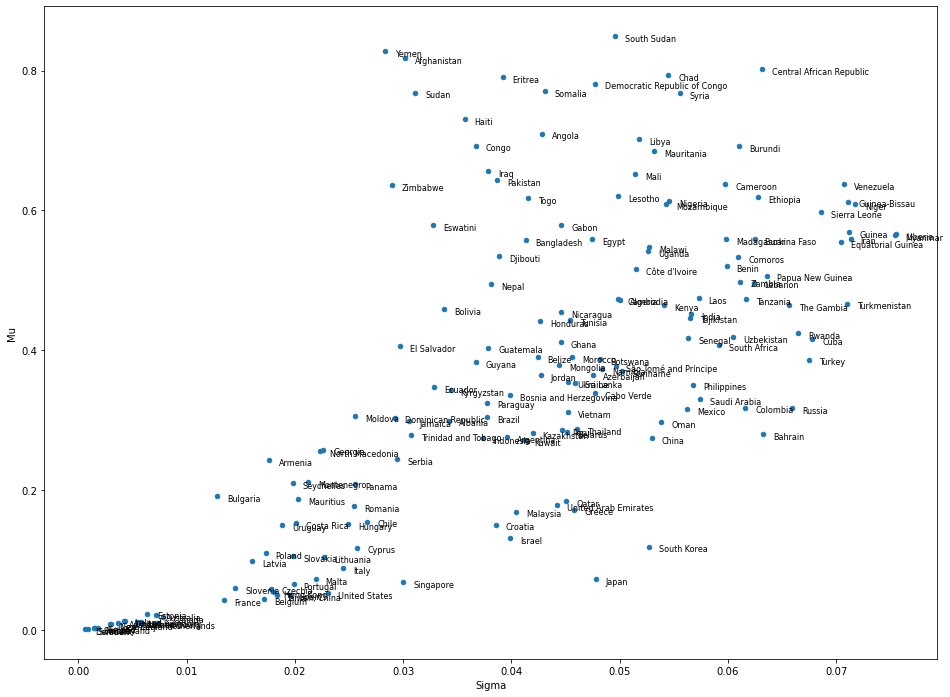

In [43]:
from matplotlib import cm

fig, ax = plt.subplots()

cmap = cm.get_cmap('Spectral')

Sigma_Mu_df.plot('Sigma', 'Mu', kind='scatter', ax=ax, figsize = (16,12))

for k, v in Sigma_Mu_df.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='black')

In [44]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] < comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Central African Republic', 'Guinea-Bissau', 'Liberia', 'Niger', 'South Sudan', 'Venezuela']
PKF_2: ['Afghanistan', 'Burundi', 'Chad', 'Ethiopia', 'Guinea', 'Myanmar', 'Sierra Leone', 'Syria', 'Yemen']
PKF_3: ['Cameroon', 'Democratic Republic of Congo', 'Eritrea', 'Iran', 'Libya', 'Mauritania']
PKF_4: ['Burkina Faso', 'Equatorial Guinea', 'Madagascar', 'Mali', 'Nigeria', 'Somalia', 'Turkmenistan']
PKF_5: ['Angola', 'Comoros', 'Cuba', 'Haiti', 'Lesotho', 'Mozambique', 'Papua New Guinea', 'Rwanda', 'Sudan', 'The Gambia']
PKF_6: ['Benin', 'Congo', 'Egypt', 'Gabon', 'Iraq', 'Lebanon', 'Malawi', 'Pakistan', 'Togo', 'Turkey', 'Zambia']
PKF_7: ['Bangladesh', 'Eswatini', 'Laos', 'Russia', 'Tanzania', 'Uganda', 'Zimbabwe']
PKF_8: ['Bahrain', 'Colombia', "Côte d'Ivoire", 'Djibouti', 'India', 'Kenya', 'Uzbekistan']
PKF_9: ['Algeria', 'Cambodia', 'Nepal', 'South Africa', 'Tajikistan']
PKF_10: ['Bolivia', 'Nicaragua', 'Philippines', 'Saudi Arabia', 'Senegal', 'Tunisia']
PKF_11: ['Botswana',

In [45]:
from PROMETHEE import optimize_PROM1_original_neg_flow, optimize_newconstraint_neg_flow

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr or a dominated one
        
        M, resultado = optimize_PROM1_original_neg_flow(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_newconstraint_neg_flow(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')

alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 1, fronteira 22: resolvido.
alternative 1, fronteira 23: resolvido.
alternative 1, fronteira 24: resolvido.
alternative 1, fronteira 25: resolvido.
alternati

alternative 6, fronteira 13: resolvido.
alternative 6, fronteira 14: resolvido.
alternative 6, fronteira 15: resolvido.
alternative 6, fronteira 16: resolvido.
alternative 6, fronteira 17: resolvido.
alternative 6, fronteira 18: resolvido.
alternative 6, fronteira 19: resolvido.
alternative 6, fronteira 20: resolvido.
alternative 6, fronteira 21: resolvido.
alternative 6, fronteira 22: resolvido.
alternative 6, fronteira 23: resolvido.
alternative 6, fronteira 24: resolvido.
alternative 6, fronteira 25: resolvido.
alternative 6, fronteira 26: resolvido.
alternative 6, fronteira 27: resolvido.
alternative 6, fronteira 28: resolvido.
alternative 6, fronteira 29: resolvido.
alternative 6, fronteira 30: resolvido.
alternative 6, fronteira 31: resolvido.
alternative 6, fronteira 32: resolvido.
alternative 6, fronteira 33: resolvido.
alternative 6, fronteira 34: resolvido.
alternative 6, fronteira 35: resolvido.
alternative 6, fronteira 36: resolvido.
alternative 6, fronteira 37: resolvido.


alternative 11, fronteira 23: resolvido.
alternative 11, fronteira 24: resolvido.
alternative 11, fronteira 25: resolvido.
alternative 11, fronteira 26: resolvido.
alternative 11, fronteira 27: resolvido.
alternative 11, fronteira 28: resolvido.
alternative 11, fronteira 29: resolvido.
alternative 11, fronteira 30: resolvido.
alternative 11, fronteira 31: resolvido.
alternative 11, fronteira 32: resolvido.
alternative 11, fronteira 33: resolvido.
alternative 11, fronteira 34: resolvido.
alternative 11, fronteira 35: resolvido.
alternative 11, fronteira 36: resolvido.
alternative 11, fronteira 37: resolvido.
alternative 11, fronteira 38: resolvido.
alternative 11, fronteira 39: resolvido.
alternative 12, fronteira 1: resolvido.
alternative 12, fronteira 2: resolvido.
alternative 12, fronteira 3: resolvido.
alternative 12, fronteira 4: resolvido.
alternative 12, fronteira 5: resolvido.
alternative 12, fronteira 6: resolvido.
alternative 12, fronteira 7: resolvido.
alternative 12, frontei

alternative 16, fronteira 29: resolvido.
alternative 16, fronteira 30: resolvido.
alternative 16, fronteira 31: resolvido.
alternative 16, fronteira 32: resolvido.
alternative 16, fronteira 33: resolvido.
alternative 16, fronteira 34: resolvido.
alternative 16, fronteira 35: resolvido.
alternative 16, fronteira 36: resolvido.
alternative 16, fronteira 37: resolvido.
alternative 16, fronteira 38: resolvido.
alternative 16, fronteira 39: resolvido.
alternative 17, fronteira 1: resolvido.
alternative 17, fronteira 2: resolvido.
alternative 17, fronteira 3: resolvido.
alternative 17, fronteira 4: resolvido.
alternative 17, fronteira 5: resolvido.
alternative 17, fronteira 6: resolvido.
alternative 17, fronteira 7: resolvido.
alternative 17, fronteira 8: resolvido.
alternative 17, fronteira 9: resolvido.
alternative 17, fronteira 10: resolvido.
alternative 17, fronteira 11: resolvido.
alternative 17, fronteira 12: resolvido.
alternative 17, fronteira 13: resolvido.
alternative 17, fronteira

alternative 21, fronteira 35: resolvido.
alternative 21, fronteira 36: resolvido.
alternative 21, fronteira 37: resolvido.
alternative 21, fronteira 38: resolvido.
alternative 21, fronteira 39: resolvido.
alternative 22, fronteira 1: resolvido.
alternative 22, fronteira 2: resolvido.
alternative 22, fronteira 3: resolvido.
alternative 22, fronteira 4: resolvido.
alternative 22, fronteira 5: resolvido.
alternative 22, fronteira 6: resolvido.
alternative 22, fronteira 7: resolvido.
alternative 22, fronteira 8: resolvido.
alternative 22, fronteira 9: resolvido.
alternative 22, fronteira 10: resolvido.
alternative 22, fronteira 11: resolvido.
alternative 22, fronteira 12: resolvido.
alternative 22, fronteira 13: resolvido.
alternative 22, fronteira 14: resolvido.
alternative 22, fronteira 15: resolvido.
alternative 22, fronteira 16: resolvido.
alternative 22, fronteira 17: resolvido.
alternative 22, fronteira 18: resolvido.
alternative 22, fronteira 19: resolvido.
alternative 22, fronteira

alternative 27, fronteira 2: resolvido.
alternative 27, fronteira 3: resolvido.
alternative 27, fronteira 4: resolvido.
alternative 27, fronteira 5: resolvido.
alternative 27, fronteira 6: resolvido.
alternative 27, fronteira 7: resolvido.
alternative 27, fronteira 8: resolvido.
alternative 27, fronteira 9: resolvido.
alternative 27, fronteira 10: resolvido.
alternative 27, fronteira 11: resolvido.
alternative 27, fronteira 12: resolvido.
alternative 27, fronteira 13: resolvido.
alternative 27, fronteira 14: resolvido.
alternative 27, fronteira 15: resolvido.
alternative 27, fronteira 16: resolvido.
alternative 27, fronteira 17: resolvido.
alternative 27, fronteira 18: resolvido.
alternative 27, fronteira 19: resolvido.
alternative 27, fronteira 20: resolvido.
alternative 27, fronteira 21: resolvido.
alternative 27, fronteira 22: resolvido.
alternative 27, fronteira 23: resolvido.
alternative 27, fronteira 24: resolvido.
alternative 27, fronteira 25: resolvido.
alternative 27, fronteir

alternative 32, fronteira 9: resolvido.
alternative 32, fronteira 10: resolvido.
alternative 32, fronteira 11: resolvido.
alternative 32, fronteira 12: resolvido.
alternative 32, fronteira 13: resolvido.
alternative 32, fronteira 14: resolvido.
alternative 32, fronteira 15: resolvido.
alternative 32, fronteira 16: resolvido.
alternative 32, fronteira 17: resolvido.
alternative 32, fronteira 18: resolvido.
alternative 32, fronteira 19: resolvido.
alternative 32, fronteira 20: resolvido.
alternative 32, fronteira 21: resolvido.
alternative 32, fronteira 22: resolvido.
alternative 32, fronteira 23: resolvido.
alternative 32, fronteira 24: resolvido.
alternative 32, fronteira 25: resolvido.
alternative 32, fronteira 26: resolvido.
alternative 32, fronteira 27: resolvido.
alternative 32, fronteira 28: resolvido.
alternative 32, fronteira 29: resolvido.
alternative 32, fronteira 30: resolvido.
alternative 32, fronteira 31: resolvido.
alternative 32, fronteira 32: resolvido.
alternative 32, f

alternative 37, fronteira 15: resolvido.
alternative 37, fronteira 16: resolvido.
alternative 37, fronteira 17: resolvido.
alternative 37, fronteira 18: resolvido.
alternative 37, fronteira 19: resolvido.
alternative 37, fronteira 20: resolvido.
alternative 37, fronteira 21: resolvido.
alternative 37, fronteira 22: resolvido.
alternative 37, fronteira 23: resolvido.
alternative 37, fronteira 24: resolvido.
alternative 37, fronteira 25: resolvido.
alternative 37, fronteira 26: resolvido.
alternative 37, fronteira 27: resolvido.
alternative 37, fronteira 28: resolvido.
alternative 37, fronteira 29: resolvido.
alternative 37, fronteira 30: resolvido.
alternative 37, fronteira 31: resolvido.
alternative 37, fronteira 32: resolvido.
alternative 37, fronteira 33: resolvido.
alternative 37, fronteira 34: resolvido.
alternative 37, fronteira 35: resolvido.
alternative 37, fronteira 36: resolvido.
alternative 37, fronteira 37: resolvido.
alternative 37, fronteira 38: resolvido.
alternative 37, 

alternative 42, fronteira 21: resolvido.
alternative 42, fronteira 22: resolvido.
alternative 42, fronteira 23: resolvido.
alternative 42, fronteira 24: resolvido.
alternative 42, fronteira 25: resolvido.
alternative 42, fronteira 26: resolvido.
alternative 42, fronteira 27: resolvido.
alternative 42, fronteira 28: resolvido.
alternative 42, fronteira 29: resolvido.
alternative 42, fronteira 30: resolvido.
alternative 42, fronteira 31: resolvido.
alternative 42, fronteira 32: resolvido.
alternative 42, fronteira 33: resolvido.
alternative 42, fronteira 34: resolvido.
alternative 42, fronteira 35: resolvido.
alternative 42, fronteira 36: resolvido.
alternative 42, fronteira 37: resolvido.
alternative 42, fronteira 38: resolvido.
alternative 42, fronteira 39: resolvido.
alternative 43, fronteira 1: resolvido.
alternative 43, fronteira 2: resolvido.
alternative 43, fronteira 3: resolvido.
alternative 43, fronteira 4: resolvido.
alternative 43, fronteira 5: resolvido.
alternative 43, front

alternative 47, fronteira 27: resolvido.
alternative 47, fronteira 28: resolvido.
alternative 47, fronteira 29: resolvido.
alternative 47, fronteira 30: resolvido.
alternative 47, fronteira 31: resolvido.
alternative 47, fronteira 32: resolvido.
alternative 47, fronteira 33: resolvido.
alternative 47, fronteira 34: resolvido.
alternative 47, fronteira 35: resolvido.
alternative 47, fronteira 36: resolvido.
alternative 47, fronteira 37: resolvido.
alternative 47, fronteira 38: resolvido.
alternative 47, fronteira 39: resolvido.
alternative 48, fronteira 1: resolvido.
alternative 48, fronteira 2: resolvido.
alternative 48, fronteira 3: resolvido.
alternative 48, fronteira 4: resolvido.
alternative 48, fronteira 5: resolvido.
alternative 48, fronteira 6: resolvido.
alternative 48, fronteira 7: resolvido.
alternative 48, fronteira 8: resolvido.
alternative 48, fronteira 9: resolvido.
alternative 48, fronteira 10: resolvido.
alternative 48, fronteira 11: resolvido.
alternative 48, fronteira

alternative 52, fronteira 33: resolvido.
alternative 52, fronteira 34: resolvido.
alternative 52, fronteira 35: resolvido.
alternative 52, fronteira 36: resolvido.
alternative 52, fronteira 37: resolvido.
alternative 52, fronteira 38: resolvido.
alternative 52, fronteira 39: resolvido.
alternative 53, fronteira 1: resolvido.
alternative 53, fronteira 2: resolvido.
alternative 53, fronteira 3: resolvido.
alternative 53, fronteira 4: resolvido.
alternative 53, fronteira 5: resolvido.
alternative 53, fronteira 6: resolvido.
alternative 53, fronteira 7: resolvido.
alternative 53, fronteira 8: resolvido.
alternative 53, fronteira 9: resolvido.
alternative 53, fronteira 10: resolvido.
alternative 53, fronteira 11: resolvido.
alternative 53, fronteira 12: resolvido.
alternative 53, fronteira 13: resolvido.
alternative 53, fronteira 14: resolvido.
alternative 53, fronteira 15: resolvido.
alternative 53, fronteira 16: resolvido.
alternative 53, fronteira 17: resolvido.
alternative 53, fronteira

alternative 57, fronteira 39: resolvido.
alternative 58, fronteira 1: resolvido.
alternative 58, fronteira 2: resolvido.
alternative 58, fronteira 3: resolvido.
alternative 58, fronteira 4: resolvido.
alternative 58, fronteira 5: resolvido.
alternative 58, fronteira 6: resolvido.
alternative 58, fronteira 7: resolvido.
alternative 58, fronteira 8: resolvido.
alternative 58, fronteira 9: resolvido.
alternative 58, fronteira 10: resolvido.
alternative 58, fronteira 11: resolvido.
alternative 58, fronteira 12: resolvido.
alternative 58, fronteira 13: resolvido.
alternative 58, fronteira 14: resolvido.
alternative 58, fronteira 15: resolvido.
alternative 58, fronteira 16: resolvido.
alternative 58, fronteira 17: resolvido.
alternative 58, fronteira 18: resolvido.
alternative 58, fronteira 19: resolvido.
alternative 58, fronteira 20: resolvido.
alternative 58, fronteira 21: resolvido.
alternative 58, fronteira 22: resolvido.
alternative 58, fronteira 23: resolvido.
alternative 58, fronteira

alternative 63, fronteira 7: resolvido.
alternative 63, fronteira 8: resolvido.
alternative 63, fronteira 9: resolvido.
alternative 63, fronteira 10: resolvido.
alternative 63, fronteira 11: resolvido.
alternative 63, fronteira 12: resolvido.
alternative 63, fronteira 13: resolvido.
alternative 63, fronteira 14: resolvido.
alternative 63, fronteira 15: resolvido.
alternative 63, fronteira 16: resolvido.
alternative 63, fronteira 17: resolvido.
alternative 63, fronteira 18: resolvido.
alternative 63, fronteira 19: resolvido.
alternative 63, fronteira 20: resolvido.
alternative 63, fronteira 21: resolvido.
alternative 63, fronteira 22: resolvido.
alternative 63, fronteira 23: resolvido.
alternative 63, fronteira 24: resolvido.
alternative 63, fronteira 25: resolvido.
alternative 63, fronteira 26: resolvido.
alternative 63, fronteira 27: resolvido.
alternative 63, fronteira 28: resolvido.
alternative 63, fronteira 29: resolvido.
alternative 63, fronteira 30: resolvido.
alternative 63, fro

alternative 68, fronteira 13: resolvido.
alternative 68, fronteira 14: resolvido.
alternative 68, fronteira 15: resolvido.
alternative 68, fronteira 16: resolvido.
alternative 68, fronteira 17: resolvido.
alternative 68, fronteira 18: resolvido.
alternative 68, fronteira 19: resolvido.
alternative 68, fronteira 20: resolvido.
alternative 68, fronteira 21: resolvido.
alternative 68, fronteira 22: resolvido.
alternative 68, fronteira 23: resolvido.
alternative 68, fronteira 24: resolvido.
alternative 68, fronteira 25: resolvido.
alternative 68, fronteira 26: resolvido.
alternative 68, fronteira 27: resolvido.
alternative 68, fronteira 28: resolvido.
alternative 68, fronteira 29: resolvido.
alternative 68, fronteira 30: resolvido.
alternative 68, fronteira 31: resolvido.
alternative 68, fronteira 32: resolvido.
alternative 68, fronteira 33: resolvido.
alternative 68, fronteira 34: resolvido.
alternative 68, fronteira 35: resolvido.
alternative 68, fronteira 36: resolvido.
alternative 68, 

alternative 73, fronteira 19: resolvido.
alternative 73, fronteira 20: resolvido.
alternative 73, fronteira 21: resolvido.
alternative 73, fronteira 22: resolvido.
alternative 73, fronteira 23: resolvido.
alternative 73, fronteira 24: resolvido.
alternative 73, fronteira 25: resolvido.
alternative 73, fronteira 26: resolvido.
alternative 73, fronteira 27: resolvido.
alternative 73, fronteira 28: resolvido.
alternative 73, fronteira 29: resolvido.
alternative 73, fronteira 30: resolvido.
alternative 73, fronteira 31: resolvido.
alternative 73, fronteira 32: resolvido.
alternative 73, fronteira 33: resolvido.
alternative 73, fronteira 34: resolvido.
alternative 73, fronteira 35: resolvido.
alternative 73, fronteira 36: resolvido.
alternative 73, fronteira 37: resolvido.
alternative 73, fronteira 38: resolvido.
alternative 73, fronteira 39: resolvido.
alternative 74, fronteira 1: resolvido.
alternative 74, fronteira 2: resolvido.
alternative 74, fronteira 3: resolvido.
alternative 74, fro

alternative 78, fronteira 25: resolvido.
alternative 78, fronteira 26: resolvido.
alternative 78, fronteira 27: resolvido.
alternative 78, fronteira 28: resolvido.
alternative 78, fronteira 29: resolvido.
alternative 78, fronteira 30: resolvido.
alternative 78, fronteira 31: resolvido.
alternative 78, fronteira 32: resolvido.
alternative 78, fronteira 33: resolvido.
alternative 78, fronteira 34: resolvido.
alternative 78, fronteira 35: resolvido.
alternative 78, fronteira 36: resolvido.
alternative 78, fronteira 37: resolvido.
alternative 78, fronteira 38: resolvido.
alternative 78, fronteira 39: resolvido.
alternative 79, fronteira 1: resolvido.
alternative 79, fronteira 2: resolvido.
alternative 79, fronteira 3: resolvido.
alternative 79, fronteira 4: resolvido.
alternative 79, fronteira 5: resolvido.
alternative 79, fronteira 6: resolvido.
alternative 79, fronteira 7: resolvido.
alternative 79, fronteira 8: resolvido.
alternative 79, fronteira 9: resolvido.
alternative 79, fronteira

alternative 83, fronteira 31: resolvido.
alternative 83, fronteira 32: resolvido.
alternative 83, fronteira 33: resolvido.
alternative 83, fronteira 34: resolvido.
alternative 83, fronteira 35: resolvido.
alternative 83, fronteira 36: resolvido.
alternative 83, fronteira 37: resolvido.
alternative 83, fronteira 38: resolvido.
alternative 83, fronteira 39: resolvido.
alternative 84, fronteira 1: resolvido.
alternative 84, fronteira 2: resolvido.
alternative 84, fronteira 3: resolvido.
alternative 84, fronteira 4: resolvido.
alternative 84, fronteira 5: resolvido.
alternative 84, fronteira 6: resolvido.
alternative 84, fronteira 7: resolvido.
alternative 84, fronteira 8: resolvido.
alternative 84, fronteira 9: resolvido.
alternative 84, fronteira 10: resolvido.
alternative 84, fronteira 11: resolvido.
alternative 84, fronteira 12: resolvido.
alternative 84, fronteira 13: resolvido.
alternative 84, fronteira 14: resolvido.
alternative 84, fronteira 15: resolvido.
alternative 84, fronteira

alternative 88, fronteira 37: resolvido.
alternative 88, fronteira 38: resolvido.
alternative 88, fronteira 39: resolvido.
alternative 89, fronteira 1: resolvido.
alternative 89, fronteira 2: resolvido.
alternative 89, fronteira 3: resolvido.
alternative 89, fronteira 4: resolvido.
alternative 89, fronteira 5: resolvido.
alternative 89, fronteira 6: resolvido.
alternative 89, fronteira 7: resolvido.
alternative 89, fronteira 8: resolvido.
alternative 89, fronteira 9: resolvido.
alternative 89, fronteira 10: resolvido.
alternative 89, fronteira 11: resolvido.
alternative 89, fronteira 12: resolvido.
alternative 89, fronteira 13: resolvido.
alternative 89, fronteira 14: resolvido.
alternative 89, fronteira 15: resolvido.
alternative 89, fronteira 16: resolvido.
alternative 89, fronteira 17: resolvido.
alternative 89, fronteira 18: resolvido.
alternative 89, fronteira 19: resolvido.
alternative 89, fronteira 20: resolvido.
alternative 89, fronteira 21: resolvido.
alternative 89, fronteira

alternative 94, fronteira 4: resolvido.
alternative 94, fronteira 5: resolvido.
alternative 94, fronteira 6: resolvido.
alternative 94, fronteira 7: resolvido.
alternative 94, fronteira 8: resolvido.
alternative 94, fronteira 9: resolvido.
alternative 94, fronteira 10: resolvido.
alternative 94, fronteira 11: resolvido.
alternative 94, fronteira 12: resolvido.
alternative 94, fronteira 13: resolvido.
alternative 94, fronteira 14: resolvido.
alternative 94, fronteira 15: resolvido.
alternative 94, fronteira 16: resolvido.
alternative 94, fronteira 17: resolvido.
alternative 94, fronteira 18: resolvido.
alternative 94, fronteira 19: resolvido.
alternative 94, fronteira 20: resolvido.
alternative 94, fronteira 21: resolvido.
alternative 94, fronteira 22: resolvido.
alternative 94, fronteira 23: resolvido.
alternative 94, fronteira 24: resolvido.
alternative 94, fronteira 25: resolvido.
alternative 94, fronteira 26: resolvido.
alternative 94, fronteira 27: resolvido.
alternative 94, fronte

alternative 99, fronteira 11: resolvido.
alternative 99, fronteira 12: resolvido.
alternative 99, fronteira 13: resolvido.
alternative 99, fronteira 14: resolvido.
alternative 99, fronteira 15: resolvido.
alternative 99, fronteira 16: resolvido.
alternative 99, fronteira 17: resolvido.
alternative 99, fronteira 18: resolvido.
alternative 99, fronteira 19: resolvido.
alternative 99, fronteira 20: resolvido.
alternative 99, fronteira 21: resolvido.
alternative 99, fronteira 22: resolvido.
alternative 99, fronteira 23: resolvido.
alternative 99, fronteira 24: resolvido.
alternative 99, fronteira 25: resolvido.
alternative 99, fronteira 26: resolvido.
alternative 99, fronteira 27: resolvido.
alternative 99, fronteira 28: resolvido.
alternative 99, fronteira 29: resolvido.
alternative 99, fronteira 30: resolvido.
alternative 99, fronteira 31: resolvido.
alternative 99, fronteira 32: resolvido.
alternative 99, fronteira 33: resolvido.
alternative 99, fronteira 34: resolvido.
alternative 99, 

alternative 104, fronteira 13: resolvido.
alternative 104, fronteira 14: resolvido.
alternative 104, fronteira 15: resolvido.
alternative 104, fronteira 16: resolvido.
alternative 104, fronteira 17: resolvido.
alternative 104, fronteira 18: resolvido.
alternative 104, fronteira 19: resolvido.
alternative 104, fronteira 20: resolvido.
alternative 104, fronteira 21: resolvido.
alternative 104, fronteira 22: resolvido.
alternative 104, fronteira 23: resolvido.
alternative 104, fronteira 24: resolvido.
alternative 104, fronteira 25: resolvido.
alternative 104, fronteira 26: resolvido.
alternative 104, fronteira 27: resolvido.
alternative 104, fronteira 28: resolvido.
alternative 104, fronteira 29: resolvido.
alternative 104, fronteira 30: resolvido.
alternative 104, fronteira 31: resolvido.
alternative 104, fronteira 32: resolvido.
alternative 104, fronteira 33: resolvido.
alternative 104, fronteira 34: resolvido.
alternative 104, fronteira 35: resolvido.
alternative 104, fronteira 36: res

alternative 109, fronteira 15: resolvido.
alternative 109, fronteira 16: resolvido.
alternative 109, fronteira 17: resolvido.
alternative 109, fronteira 18: resolvido.
alternative 109, fronteira 19: resolvido.
alternative 109, fronteira 20: resolvido.
alternative 109, fronteira 21: resolvido.
alternative 109, fronteira 22: resolvido.
alternative 109, fronteira 23: resolvido.
alternative 109, fronteira 24: resolvido.
alternative 109, fronteira 25: resolvido.
alternative 109, fronteira 26: resolvido.
alternative 109, fronteira 27: resolvido.
alternative 109, fronteira 28: resolvido.
alternative 109, fronteira 29: resolvido.
alternative 109, fronteira 30: resolvido.
alternative 109, fronteira 31: resolvido.
alternative 109, fronteira 32: resolvido.
alternative 109, fronteira 33: resolvido.
alternative 109, fronteira 34: resolvido.
alternative 109, fronteira 35: resolvido.
alternative 109, fronteira 36: resolvido.
alternative 109, fronteira 37: resolvido.
alternative 109, fronteira 38: res

alternative 114, fronteira 17: resolvido.
alternative 114, fronteira 18: resolvido.
alternative 114, fronteira 19: resolvido.
alternative 114, fronteira 20: resolvido.
alternative 114, fronteira 21: resolvido.
alternative 114, fronteira 22: resolvido.
alternative 114, fronteira 23: resolvido.
alternative 114, fronteira 24: resolvido.
alternative 114, fronteira 25: resolvido.
alternative 114, fronteira 26: resolvido.
alternative 114, fronteira 27: resolvido.
alternative 114, fronteira 28: resolvido.
alternative 114, fronteira 29: resolvido.
alternative 114, fronteira 30: resolvido.
alternative 114, fronteira 31: resolvido.
alternative 114, fronteira 32: resolvido.
alternative 114, fronteira 33: resolvido.
alternative 114, fronteira 34: resolvido.
alternative 114, fronteira 35: resolvido.
alternative 114, fronteira 36: resolvido.
alternative 114, fronteira 37: resolvido.
alternative 114, fronteira 38: resolvido.
alternative 114, fronteira 39: resolvido.
alternative 115, fronteira 1: reso

alternative 119, fronteira 19: resolvido.
alternative 119, fronteira 20: resolvido.
alternative 119, fronteira 21: resolvido.
alternative 119, fronteira 22: resolvido.
alternative 119, fronteira 23: resolvido.
alternative 119, fronteira 24: resolvido.
alternative 119, fronteira 25: resolvido.
alternative 119, fronteira 26: resolvido.
alternative 119, fronteira 27: resolvido.
alternative 119, fronteira 28: resolvido.
alternative 119, fronteira 29: resolvido.
alternative 119, fronteira 30: resolvido.
alternative 119, fronteira 31: resolvido.
alternative 119, fronteira 32: resolvido.
alternative 119, fronteira 33: resolvido.
alternative 119, fronteira 34: resolvido.
alternative 119, fronteira 35: resolvido.
alternative 119, fronteira 36: resolvido.
alternative 119, fronteira 37: resolvido.
alternative 119, fronteira 38: resolvido.
alternative 119, fronteira 39: resolvido.
alternative 120, fronteira 1: resolvido.
alternative 120, fronteira 2: resolvido.
alternative 120, fronteira 3: resolv

alternative 124, fronteira 21: resolvido.
alternative 124, fronteira 22: resolvido.
alternative 124, fronteira 23: resolvido.
alternative 124, fronteira 24: resolvido.
alternative 124, fronteira 25: resolvido.
alternative 124, fronteira 26: resolvido.
alternative 124, fronteira 27: resolvido.
alternative 124, fronteira 28: resolvido.
alternative 124, fronteira 29: resolvido.
alternative 124, fronteira 30: resolvido.
alternative 124, fronteira 31: resolvido.
alternative 124, fronteira 32: resolvido.
alternative 124, fronteira 33: resolvido.
alternative 124, fronteira 34: resolvido.
alternative 124, fronteira 35: resolvido.
alternative 124, fronteira 36: resolvido.
alternative 124, fronteira 37: resolvido.
alternative 124, fronteira 38: resolvido.
alternative 124, fronteira 39: resolvido.
alternative 125, fronteira 1: resolvido.
alternative 125, fronteira 2: resolvido.
alternative 125, fronteira 3: resolvido.
alternative 125, fronteira 4: resolvido.
alternative 125, fronteira 5: resolvid

alternative 129, fronteira 23: resolvido.
alternative 129, fronteira 24: resolvido.
alternative 129, fronteira 25: resolvido.
alternative 129, fronteira 26: resolvido.
alternative 129, fronteira 27: resolvido.
alternative 129, fronteira 28: resolvido.
alternative 129, fronteira 29: resolvido.
alternative 129, fronteira 30: resolvido.
alternative 129, fronteira 31: resolvido.
alternative 129, fronteira 32: resolvido.
alternative 129, fronteira 33: resolvido.
alternative 129, fronteira 34: resolvido.
alternative 129, fronteira 35: resolvido.
alternative 129, fronteira 36: resolvido.
alternative 129, fronteira 37: resolvido.
alternative 129, fronteira 38: resolvido.
alternative 129, fronteira 39: resolvido.
alternative 130, fronteira 1: resolvido.
alternative 130, fronteira 2: resolvido.
alternative 130, fronteira 3: resolvido.
alternative 130, fronteira 4: resolvido.
alternative 130, fronteira 5: resolvido.
alternative 130, fronteira 6: resolvido.
alternative 130, fronteira 7: resolvido.

alternative 134, fronteira 25: resolvido.
alternative 134, fronteira 26: resolvido.
alternative 134, fronteira 27: resolvido.
alternative 134, fronteira 28: resolvido.
alternative 134, fronteira 29: resolvido.
alternative 134, fronteira 30: resolvido.
alternative 134, fronteira 31: resolvido.
alternative 134, fronteira 32: resolvido.
alternative 134, fronteira 33: resolvido.
alternative 134, fronteira 34: resolvido.
alternative 134, fronteira 35: resolvido.
alternative 134, fronteira 36: resolvido.
alternative 134, fronteira 37: resolvido.
alternative 134, fronteira 38: resolvido.
alternative 134, fronteira 39: resolvido.
alternative 135, fronteira 1: resolvido.
alternative 135, fronteira 2: resolvido.
alternative 135, fronteira 3: resolvido.
alternative 135, fronteira 4: resolvido.
alternative 135, fronteira 5: resolvido.
alternative 135, fronteira 6: resolvido.
alternative 135, fronteira 7: resolvido.
alternative 135, fronteira 8: resolvido.
alternative 135, fronteira 9: resolvido.
a

alternative 139, fronteira 27: resolvido.
alternative 139, fronteira 28: resolvido.
alternative 139, fronteira 29: resolvido.
alternative 139, fronteira 30: resolvido.
alternative 139, fronteira 31: resolvido.
alternative 139, fronteira 32: resolvido.
alternative 139, fronteira 33: resolvido.
alternative 139, fronteira 34: resolvido.
alternative 139, fronteira 35: resolvido.
alternative 139, fronteira 36: resolvido.
alternative 139, fronteira 37: resolvido.
alternative 139, fronteira 38: resolvido.
alternative 139, fronteira 39: resolvido.
alternative 140, fronteira 1: resolvido.
alternative 140, fronteira 2: resolvido.
alternative 140, fronteira 3: resolvido.
alternative 140, fronteira 4: resolvido.
alternative 140, fronteira 5: resolvido.
alternative 140, fronteira 6: resolvido.
alternative 140, fronteira 7: resolvido.
alternative 140, fronteira 8: resolvido.
alternative 140, fronteira 9: resolvido.
alternative 140, fronteira 10: resolvido.
alternative 140, fronteira 11: resolvido.
a

alternative 144, fronteira 29: resolvido.
alternative 144, fronteira 30: resolvido.
alternative 144, fronteira 31: resolvido.
alternative 144, fronteira 32: resolvido.
alternative 144, fronteira 33: resolvido.
alternative 144, fronteira 34: resolvido.
alternative 144, fronteira 35: resolvido.
alternative 144, fronteira 36: resolvido.
alternative 144, fronteira 37: resolvido.
alternative 144, fronteira 38: resolvido.
alternative 144, fronteira 39: resolvido.
alternative 145, fronteira 1: resolvido.
alternative 145, fronteira 2: resolvido.
alternative 145, fronteira 3: resolvido.
alternative 145, fronteira 4: resolvido.
alternative 145, fronteira 5: resolvido.
alternative 145, fronteira 6: resolvido.
alternative 145, fronteira 7: resolvido.
alternative 145, fronteira 8: resolvido.
alternative 145, fronteira 9: resolvido.
alternative 145, fronteira 10: resolvido.
alternative 145, fronteira 11: resolvido.
alternative 145, fronteira 12: resolvido.
alternative 145, fronteira 13: resolvido.
a

alternative 149, fronteira 31: resolvido.
alternative 149, fronteira 32: resolvido.
alternative 149, fronteira 33: resolvido.
alternative 149, fronteira 34: resolvido.
alternative 149, fronteira 35: resolvido.
alternative 149, fronteira 36: resolvido.
alternative 149, fronteira 37: resolvido.
alternative 149, fronteira 38: resolvido.
alternative 149, fronteira 39: resolvido.
alternative 150, fronteira 1: resolvido.
alternative 150, fronteira 2: resolvido.
alternative 150, fronteira 3: resolvido.
alternative 150, fronteira 4: resolvido.
alternative 150, fronteira 5: resolvido.
alternative 150, fronteira 6: resolvido.
alternative 150, fronteira 7: resolvido.
alternative 150, fronteira 8: resolvido.
alternative 150, fronteira 9: resolvido.
alternative 150, fronteira 10: resolvido.
alternative 150, fronteira 11: resolvido.
alternative 150, fronteira 12: resolvido.
alternative 150, fronteira 13: resolvido.
alternative 150, fronteira 14: resolvido.
alternative 150, fronteira 15: resolvido.
a

alternative 154, fronteira 33: resolvido.
alternative 154, fronteira 34: resolvido.
alternative 154, fronteira 35: resolvido.
alternative 154, fronteira 36: resolvido.
alternative 154, fronteira 37: resolvido.
alternative 154, fronteira 38: resolvido.
alternative 154, fronteira 39: resolvido.
alternative 155, fronteira 1: resolvido.
alternative 155, fronteira 2: resolvido.
alternative 155, fronteira 3: resolvido.
alternative 155, fronteira 4: resolvido.
alternative 155, fronteira 5: resolvido.
alternative 155, fronteira 6: resolvido.
alternative 155, fronteira 7: resolvido.
alternative 155, fronteira 8: resolvido.
alternative 155, fronteira 9: resolvido.
alternative 155, fronteira 10: resolvido.
alternative 155, fronteira 11: resolvido.
alternative 155, fronteira 12: resolvido.
alternative 155, fronteira 13: resolvido.
alternative 155, fronteira 14: resolvido.
alternative 155, fronteira 15: resolvido.
alternative 155, fronteira 16: resolvido.
alternative 155, fronteira 17: resolvido.
a

alternative 159, fronteira 35: resolvido.
alternative 159, fronteira 36: resolvido.
alternative 159, fronteira 37: resolvido.
alternative 159, fronteira 38: resolvido.
alternative 159, fronteira 39: resolvido.
alternative 160, fronteira 1: resolvido.
alternative 160, fronteira 2: resolvido.
alternative 160, fronteira 3: resolvido.
alternative 160, fronteira 4: resolvido.
alternative 160, fronteira 5: resolvido.
alternative 160, fronteira 6: resolvido.
alternative 160, fronteira 7: resolvido.
alternative 160, fronteira 8: resolvido.
alternative 160, fronteira 9: resolvido.
alternative 160, fronteira 10: resolvido.
alternative 160, fronteira 11: resolvido.
alternative 160, fronteira 12: resolvido.
alternative 160, fronteira 13: resolvido.
alternative 160, fronteira 14: resolvido.
alternative 160, fronteira 15: resolvido.
alternative 160, fronteira 16: resolvido.
alternative 160, fronteira 17: resolvido.
alternative 160, fronteira 18: resolvido.
alternative 160, fronteira 19: resolvido.
a

alternative 164, fronteira 37: resolvido.
alternative 164, fronteira 38: resolvido.
alternative 164, fronteira 39: resolvido.
alternative 165, fronteira 1: resolvido.
alternative 165, fronteira 2: resolvido.
alternative 165, fronteira 3: resolvido.
alternative 165, fronteira 4: resolvido.
alternative 165, fronteira 5: resolvido.
alternative 165, fronteira 6: resolvido.
alternative 165, fronteira 7: resolvido.
alternative 165, fronteira 8: resolvido.
alternative 165, fronteira 9: resolvido.
alternative 165, fronteira 10: resolvido.
alternative 165, fronteira 11: resolvido.
alternative 165, fronteira 12: resolvido.
alternative 165, fronteira 13: resolvido.
alternative 165, fronteira 14: resolvido.
alternative 165, fronteira 15: resolvido.
alternative 165, fronteira 16: resolvido.
alternative 165, fronteira 17: resolvido.
alternative 165, fronteira 18: resolvido.
alternative 165, fronteira 19: resolvido.
alternative 165, fronteira 20: resolvido.
alternative 165, fronteira 21: resolvido.
a

In [46]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Yemen"]

Global Efficiency    20.571406
Position              2.000000
Name: Yemen, dtype: float64

In [47]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Yemen"]

Global Efficiency    20.542673
Position              2.000000
Name: Yemen, dtype: float64

## FORMULAÇÃO 4.2.2.5 

### PROMETHEE I - FLUXO POSITIVO E NEGATIVO JUNTOS

In [49]:
X = np.array(dados) # decision matrix
m, n = X.shape
q = np.array([5 for j in range (n)]) # indiference thresholds vector
p = np.array([10 for j in range (n)]) # preference thresholds vector
s_curve = [0 for j in range (n)]
pref = [5 for j in range (n)]
w = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights

In [ ]:
# Aplica o PROMETHEE_1 ao nosso conjunto de dados

pos_flows,neg_flows = PROMETHEE_2(Decision_Matrix = X, q_thresholds=q, p_thresholds= p, scurve_thresholds = s_curve, weights = w, pref_functions= pref)[1:3]


In [51]:
pd.DataFrame(pos_flows, index=dados.index).loc["Brazil"]

0    0.090433
Name: Brazil, dtype: float64

In [52]:
pd.DataFrame(neg_flows, index=dados.index).loc["Brazil"]

0    0.383693
Name: Brazil, dtype: float64

In [53]:
n_simulations = 30

W = np.zeros(shape = (n, n_simulations))
P = np.zeros(shape = (n, n_simulations))
Q = np.zeros(shape = (n, n_simulations))

Net_Flows = np.zeros(shape = (m, n_simulations))
Pos_Flows = np.zeros(shape = (m, n_simulations))
Neg_Flows = np.zeros(shape = (m, n_simulations))
results = [[] for s in range (n_simulations)]

# Usaremos sempre a função de preferência do tipo 5
s_curve = [0 for j in range (n)] 
pref = [5 for j in range (n)]

for s in range (n_simulations):
    W [:,s] = np.random.dirichlet(np.ones(n),size=1).reshape(n) # weights
    Q [:,s] = np.random.uniform (2,6, n)
    P [:,s] = np.random.uniform (8, 12, n)
    results[s], Net_Flows[:,s], Pos_Flows[:,s], Neg_Flows[:,s] = PROMETHEE_2 (X, Q[:,s], P[:,s], s_curve, W[:,s], pref)
    print (f'simulation {s+1} completed')

simulation 1 completed
simulation 2 completed
simulation 3 completed
simulation 4 completed
simulation 5 completed
simulation 6 completed
simulation 7 completed
simulation 8 completed
simulation 9 completed
simulation 10 completed
simulation 11 completed
simulation 12 completed
simulation 13 completed
simulation 14 completed
simulation 15 completed
simulation 16 completed
simulation 17 completed
simulation 18 completed
simulation 19 completed
simulation 20 completed
simulation 21 completed
simulation 22 completed
simulation 23 completed
simulation 24 completed
simulation 25 completed
simulation 26 completed
simulation 27 completed
simulation 28 completed
simulation 29 completed
simulation 30 completed


In [54]:
mu_pos = np.mean(Pos_Flows, axis=1)
sigma_pos = np.std(Pos_Flows, axis=1)
mu_neg = np.mean(Neg_Flows, axis=1)
sigma_neg = np.std(Neg_Flows, axis=1)

#Construindo um DataFrame dos resultados
Sigma_Mu_df = pd.DataFrame({"Sigma_pos": sigma_pos,"Mu_pos": mu_pos, "Sigma_neg": sigma_neg,"Mu_neg": mu_neg}, index= dados.index)
Sigma_Mu_df.columns

Index(['Sigma_pos', 'Mu_pos', 'Sigma_neg', 'Mu_neg'], dtype='object')

In [55]:
df =Sigma_Mu_df.copy()
PKF=[]
count=0
while df.shape[0]>0:
    PKF.append([])
    for idx in df.index:
        comp_df = df.copy()
        comp_df.drop(index = idx)
        if any([any([
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])), # loose in both dimensions
                ((df.loc[idx][0] > comp_df.iloc[i,0]) and (df.loc[idx][1] == comp_df.iloc[i,1])), # loose in first dimension and drow in second
                ((df.loc[idx][0] == comp_df.iloc[i,0]) and (df.loc[idx][1] < comp_df.iloc[i,1])) # loose in the second dimension 
                    ]) for i in range (comp_df.shape[0])]
                ) == False:
            PKF[count].append(idx)
    
    if len(PKF[count]) == 0:
        PKF[count].append(df.index)
        break
    else:
        df = df.drop(index=PKF[count])
        print(f'PKF_{str(count+1)}: {PKF[count]}')
        count+=1

PKF_1: ['Cameroon', 'Ethiopia', 'Germany', 'Iceland', 'Norway', 'Somalia', 'Yemen']
PKF_2: ['Afghanistan', 'Burundi', 'Denmark', 'South Sudan', 'Sudan', 'Sweden', 'Switzerland', 'Uganda']
PKF_3: ['Angola', 'Central African Republic', 'Democratic Republic of Congo', 'Eritrea', 'Finland', 'Luxembourg', 'United Kingdom']
PKF_4: ['Austria', 'Chad', 'Ireland', 'Netherlands', 'New Zealand', 'Tanzania']
PKF_5: ['Australia', "Côte d'Ivoire", 'Zimbabwe']
PKF_6: ['Canada', 'Mauritania', 'Nigeria']
PKF_7: ['Congo', 'Estonia', 'Eswatini', 'Guatemala', 'Guyana', 'Honduras', 'Seychelles', 'Singapore']
PKF_8: ['Bangladesh', 'Bulgaria', 'Dominican Republic', 'Haiti', 'Hungary', 'Nepal', 'Pakistan', 'Panama', 'Sri Lanka', 'United States']
PKF_9: ['Djibouti', 'France', 'Japan', 'Kyrgyzstan', 'Mali', 'Paraguay', 'Slovenia', 'Spain', 'Togo', 'Uruguay']
PKF_10: ['Czechia', 'Kenya', 'Madagascar', 'Malta', 'Moldova', 'North Macedonia', 'Poland', 'Slovakia', 'Syria', 'Taiwan, China']
PKF_11: ['Armenia', 'Belg

In [56]:
from PROMETHEE import optimize_PROM1_original, optimize_PROM1_newconstraint

m = Sigma_Mu_df.shape[0] # number of alternatives
m_f = len(PKF) # number of frontiers
local_ef = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))
local_ef_new = np.zeros(shape = (Sigma_Mu_df.shape[0], len(PKF)))

for unit in range (m):
    for fr in range (m_f):
        unit_sigmamu = np.array([Sigma_Mu_df.iloc[unit]]) # get the alternative unit
        
        for k in range(fr, m_f):
            for l in range(len(PKF[k])):
                Fr_list.append(PKF[k][l])
        Fr_sigmamu = np.array (Sigma_Mu_df.loc[PKF[fr]]) # get alternatives within frontier fr or a dominated one
        
        M, resultado = optimize_PROM1_original(unit_sigmamu, Fr_sigmamu)
        local_ef[unit, fr] = M.obj()

        M_new, resultado_new = optimize_PROM1_newconstraint(unit_sigmamu, Fr_sigmamu)
        local_ef_new[unit, fr] = M_new.obj()
        
        print(f'alternative {unit+1}, fronteira {fr + 1}: resolvido.')
        
        #print(f'local_ef = {local_ef[unit, fr]}')


alternative 1, fronteira 1: resolvido.
alternative 1, fronteira 2: resolvido.
alternative 1, fronteira 3: resolvido.
alternative 1, fronteira 4: resolvido.
alternative 1, fronteira 5: resolvido.
alternative 1, fronteira 6: resolvido.
alternative 1, fronteira 7: resolvido.
alternative 1, fronteira 8: resolvido.
alternative 1, fronteira 9: resolvido.
alternative 1, fronteira 10: resolvido.
alternative 1, fronteira 11: resolvido.
alternative 1, fronteira 12: resolvido.
alternative 1, fronteira 13: resolvido.
alternative 1, fronteira 14: resolvido.
alternative 1, fronteira 15: resolvido.
alternative 1, fronteira 16: resolvido.
alternative 1, fronteira 17: resolvido.
alternative 1, fronteira 18: resolvido.
alternative 1, fronteira 19: resolvido.
alternative 1, fronteira 20: resolvido.
alternative 1, fronteira 21: resolvido.
alternative 2, fronteira 1: resolvido.
alternative 2, fronteira 2: resolvido.
alternative 2, fronteira 3: resolvido.
alternative 2, fronteira 4: resolvido.
alternative 2

alternative 10, fronteira 19: resolvido.
alternative 10, fronteira 20: resolvido.
alternative 10, fronteira 21: resolvido.
alternative 11, fronteira 1: resolvido.
alternative 11, fronteira 2: resolvido.
alternative 11, fronteira 3: resolvido.
alternative 11, fronteira 4: resolvido.
alternative 11, fronteira 5: resolvido.
alternative 11, fronteira 6: resolvido.
alternative 11, fronteira 7: resolvido.
alternative 11, fronteira 8: resolvido.
alternative 11, fronteira 9: resolvido.
alternative 11, fronteira 10: resolvido.
alternative 11, fronteira 11: resolvido.
alternative 11, fronteira 12: resolvido.
alternative 11, fronteira 13: resolvido.
alternative 11, fronteira 14: resolvido.
alternative 11, fronteira 15: resolvido.
alternative 11, fronteira 16: resolvido.
alternative 11, fronteira 17: resolvido.
alternative 11, fronteira 18: resolvido.
alternative 11, fronteira 19: resolvido.
alternative 11, fronteira 20: resolvido.
alternative 11, fronteira 21: resolvido.
alternative 12, fronteira

alternative 20, fronteira 12: resolvido.
alternative 20, fronteira 13: resolvido.
alternative 20, fronteira 14: resolvido.
alternative 20, fronteira 15: resolvido.
alternative 20, fronteira 16: resolvido.
alternative 20, fronteira 17: resolvido.
alternative 20, fronteira 18: resolvido.
alternative 20, fronteira 19: resolvido.
alternative 20, fronteira 20: resolvido.
alternative 20, fronteira 21: resolvido.
alternative 21, fronteira 1: resolvido.
alternative 21, fronteira 2: resolvido.
alternative 21, fronteira 3: resolvido.
alternative 21, fronteira 4: resolvido.
alternative 21, fronteira 5: resolvido.
alternative 21, fronteira 6: resolvido.
alternative 21, fronteira 7: resolvido.
alternative 21, fronteira 8: resolvido.
alternative 21, fronteira 9: resolvido.
alternative 21, fronteira 10: resolvido.
alternative 21, fronteira 11: resolvido.
alternative 21, fronteira 12: resolvido.
alternative 21, fronteira 13: resolvido.
alternative 21, fronteira 14: resolvido.
alternative 21, fronteira

alternative 30, fronteira 4: resolvido.
alternative 30, fronteira 5: resolvido.
alternative 30, fronteira 6: resolvido.
alternative 30, fronteira 7: resolvido.
alternative 30, fronteira 8: resolvido.
alternative 30, fronteira 9: resolvido.
alternative 30, fronteira 10: resolvido.
alternative 30, fronteira 11: resolvido.
alternative 30, fronteira 12: resolvido.
alternative 30, fronteira 13: resolvido.
alternative 30, fronteira 14: resolvido.
alternative 30, fronteira 15: resolvido.
alternative 30, fronteira 16: resolvido.
alternative 30, fronteira 17: resolvido.
alternative 30, fronteira 18: resolvido.
alternative 30, fronteira 19: resolvido.
alternative 30, fronteira 20: resolvido.
alternative 30, fronteira 21: resolvido.
alternative 31, fronteira 1: resolvido.
alternative 31, fronteira 2: resolvido.
alternative 31, fronteira 3: resolvido.
alternative 31, fronteira 4: resolvido.
alternative 31, fronteira 5: resolvido.
alternative 31, fronteira 6: resolvido.
alternative 31, fronteira 7:

alternative 39, fronteira 17: resolvido.
alternative 39, fronteira 18: resolvido.
alternative 39, fronteira 19: resolvido.
alternative 39, fronteira 20: resolvido.
alternative 39, fronteira 21: resolvido.
alternative 40, fronteira 1: resolvido.
alternative 40, fronteira 2: resolvido.
alternative 40, fronteira 3: resolvido.
alternative 40, fronteira 4: resolvido.
alternative 40, fronteira 5: resolvido.
alternative 40, fronteira 6: resolvido.
alternative 40, fronteira 7: resolvido.
alternative 40, fronteira 8: resolvido.
alternative 40, fronteira 9: resolvido.
alternative 40, fronteira 10: resolvido.
alternative 40, fronteira 11: resolvido.
alternative 40, fronteira 12: resolvido.
alternative 40, fronteira 13: resolvido.
alternative 40, fronteira 14: resolvido.
alternative 40, fronteira 15: resolvido.
alternative 40, fronteira 16: resolvido.
alternative 40, fronteira 17: resolvido.
alternative 40, fronteira 18: resolvido.
alternative 40, fronteira 19: resolvido.
alternative 40, fronteira

alternative 49, fronteira 9: resolvido.
alternative 49, fronteira 10: resolvido.
alternative 49, fronteira 11: resolvido.
alternative 49, fronteira 12: resolvido.
alternative 49, fronteira 13: resolvido.
alternative 49, fronteira 14: resolvido.
alternative 49, fronteira 15: resolvido.
alternative 49, fronteira 16: resolvido.
alternative 49, fronteira 17: resolvido.
alternative 49, fronteira 18: resolvido.
alternative 49, fronteira 19: resolvido.
alternative 49, fronteira 20: resolvido.
alternative 49, fronteira 21: resolvido.
alternative 50, fronteira 1: resolvido.
alternative 50, fronteira 2: resolvido.
alternative 50, fronteira 3: resolvido.
alternative 50, fronteira 4: resolvido.
alternative 50, fronteira 5: resolvido.
alternative 50, fronteira 6: resolvido.
alternative 50, fronteira 7: resolvido.
alternative 50, fronteira 8: resolvido.
alternative 50, fronteira 9: resolvido.
alternative 50, fronteira 10: resolvido.
alternative 50, fronteira 11: resolvido.
alternative 50, fronteira 

alternative 59, fronteira 1: resolvido.
alternative 59, fronteira 2: resolvido.
alternative 59, fronteira 3: resolvido.
alternative 59, fronteira 4: resolvido.
alternative 59, fronteira 5: resolvido.
alternative 59, fronteira 6: resolvido.
alternative 59, fronteira 7: resolvido.
alternative 59, fronteira 8: resolvido.
alternative 59, fronteira 9: resolvido.
alternative 59, fronteira 10: resolvido.
alternative 59, fronteira 11: resolvido.
alternative 59, fronteira 12: resolvido.
alternative 59, fronteira 13: resolvido.
alternative 59, fronteira 14: resolvido.
alternative 59, fronteira 15: resolvido.
alternative 59, fronteira 16: resolvido.
alternative 59, fronteira 17: resolvido.
alternative 59, fronteira 18: resolvido.
alternative 59, fronteira 19: resolvido.
alternative 59, fronteira 20: resolvido.
alternative 59, fronteira 21: resolvido.
alternative 60, fronteira 1: resolvido.
alternative 60, fronteira 2: resolvido.
alternative 60, fronteira 3: resolvido.
alternative 60, fronteira 4:

alternative 68, fronteira 15: resolvido.
alternative 68, fronteira 16: resolvido.
alternative 68, fronteira 17: resolvido.
alternative 68, fronteira 18: resolvido.
alternative 68, fronteira 19: resolvido.
alternative 68, fronteira 20: resolvido.
alternative 68, fronteira 21: resolvido.
alternative 69, fronteira 1: resolvido.
alternative 69, fronteira 2: resolvido.
alternative 69, fronteira 3: resolvido.
alternative 69, fronteira 4: resolvido.
alternative 69, fronteira 5: resolvido.
alternative 69, fronteira 6: resolvido.
alternative 69, fronteira 7: resolvido.
alternative 69, fronteira 8: resolvido.
alternative 69, fronteira 9: resolvido.
alternative 69, fronteira 10: resolvido.
alternative 69, fronteira 11: resolvido.
alternative 69, fronteira 12: resolvido.
alternative 69, fronteira 13: resolvido.
alternative 69, fronteira 14: resolvido.
alternative 69, fronteira 15: resolvido.
alternative 69, fronteira 16: resolvido.
alternative 69, fronteira 17: resolvido.
alternative 69, fronteira

alternative 78, fronteira 7: resolvido.
alternative 78, fronteira 8: resolvido.
alternative 78, fronteira 9: resolvido.
alternative 78, fronteira 10: resolvido.
alternative 78, fronteira 11: resolvido.
alternative 78, fronteira 12: resolvido.
alternative 78, fronteira 13: resolvido.
alternative 78, fronteira 14: resolvido.
alternative 78, fronteira 15: resolvido.
alternative 78, fronteira 16: resolvido.
alternative 78, fronteira 17: resolvido.
alternative 78, fronteira 18: resolvido.
alternative 78, fronteira 19: resolvido.
alternative 78, fronteira 20: resolvido.
alternative 78, fronteira 21: resolvido.
alternative 79, fronteira 1: resolvido.
alternative 79, fronteira 2: resolvido.
alternative 79, fronteira 3: resolvido.
alternative 79, fronteira 4: resolvido.
alternative 79, fronteira 5: resolvido.
alternative 79, fronteira 6: resolvido.
alternative 79, fronteira 7: resolvido.
alternative 79, fronteira 8: resolvido.
alternative 79, fronteira 9: resolvido.
alternative 79, fronteira 10

alternative 87, fronteira 20: resolvido.
alternative 87, fronteira 21: resolvido.
alternative 88, fronteira 1: resolvido.
alternative 88, fronteira 2: resolvido.
alternative 88, fronteira 3: resolvido.
alternative 88, fronteira 4: resolvido.
alternative 88, fronteira 5: resolvido.
alternative 88, fronteira 6: resolvido.
alternative 88, fronteira 7: resolvido.
alternative 88, fronteira 8: resolvido.
alternative 88, fronteira 9: resolvido.
alternative 88, fronteira 10: resolvido.
alternative 88, fronteira 11: resolvido.
alternative 88, fronteira 12: resolvido.
alternative 88, fronteira 13: resolvido.
alternative 88, fronteira 14: resolvido.
alternative 88, fronteira 15: resolvido.
alternative 88, fronteira 16: resolvido.
alternative 88, fronteira 17: resolvido.
alternative 88, fronteira 18: resolvido.
alternative 88, fronteira 19: resolvido.
alternative 88, fronteira 20: resolvido.
alternative 88, fronteira 21: resolvido.
alternative 89, fronteira 1: resolvido.
alternative 89, fronteira 

alternative 97, fronteira 13: resolvido.
alternative 97, fronteira 14: resolvido.
alternative 97, fronteira 15: resolvido.
alternative 97, fronteira 16: resolvido.
alternative 97, fronteira 17: resolvido.
alternative 97, fronteira 18: resolvido.
alternative 97, fronteira 19: resolvido.
alternative 97, fronteira 20: resolvido.
alternative 97, fronteira 21: resolvido.
alternative 98, fronteira 1: resolvido.
alternative 98, fronteira 2: resolvido.
alternative 98, fronteira 3: resolvido.
alternative 98, fronteira 4: resolvido.
alternative 98, fronteira 5: resolvido.
alternative 98, fronteira 6: resolvido.
alternative 98, fronteira 7: resolvido.
alternative 98, fronteira 8: resolvido.
alternative 98, fronteira 9: resolvido.
alternative 98, fronteira 10: resolvido.
alternative 98, fronteira 11: resolvido.
alternative 98, fronteira 12: resolvido.
alternative 98, fronteira 13: resolvido.
alternative 98, fronteira 14: resolvido.
alternative 98, fronteira 15: resolvido.
alternative 98, fronteira

alternative 107, fronteira 2: resolvido.
alternative 107, fronteira 3: resolvido.
alternative 107, fronteira 4: resolvido.
alternative 107, fronteira 5: resolvido.
alternative 107, fronteira 6: resolvido.
alternative 107, fronteira 7: resolvido.
alternative 107, fronteira 8: resolvido.
alternative 107, fronteira 9: resolvido.
alternative 107, fronteira 10: resolvido.
alternative 107, fronteira 11: resolvido.
alternative 107, fronteira 12: resolvido.
alternative 107, fronteira 13: resolvido.
alternative 107, fronteira 14: resolvido.
alternative 107, fronteira 15: resolvido.
alternative 107, fronteira 16: resolvido.
alternative 107, fronteira 17: resolvido.
alternative 107, fronteira 18: resolvido.
alternative 107, fronteira 19: resolvido.
alternative 107, fronteira 20: resolvido.
alternative 107, fronteira 21: resolvido.
alternative 108, fronteira 1: resolvido.
alternative 108, fronteira 2: resolvido.
alternative 108, fronteira 3: resolvido.
alternative 108, fronteira 4: resolvido.
alte

alternative 116, fronteira 11: resolvido.
alternative 116, fronteira 12: resolvido.
alternative 116, fronteira 13: resolvido.
alternative 116, fronteira 14: resolvido.
alternative 116, fronteira 15: resolvido.
alternative 116, fronteira 16: resolvido.
alternative 116, fronteira 17: resolvido.
alternative 116, fronteira 18: resolvido.
alternative 116, fronteira 19: resolvido.
alternative 116, fronteira 20: resolvido.
alternative 116, fronteira 21: resolvido.
alternative 117, fronteira 1: resolvido.
alternative 117, fronteira 2: resolvido.
alternative 117, fronteira 3: resolvido.
alternative 117, fronteira 4: resolvido.
alternative 117, fronteira 5: resolvido.
alternative 117, fronteira 6: resolvido.
alternative 117, fronteira 7: resolvido.
alternative 117, fronteira 8: resolvido.
alternative 117, fronteira 9: resolvido.
alternative 117, fronteira 10: resolvido.
alternative 117, fronteira 11: resolvido.
alternative 117, fronteira 12: resolvido.
alternative 117, fronteira 13: resolvido.
a

alternative 125, fronteira 19: resolvido.
alternative 125, fronteira 20: resolvido.
alternative 125, fronteira 21: resolvido.
alternative 126, fronteira 1: resolvido.
alternative 126, fronteira 2: resolvido.
alternative 126, fronteira 3: resolvido.
alternative 126, fronteira 4: resolvido.
alternative 126, fronteira 5: resolvido.
alternative 126, fronteira 6: resolvido.
alternative 126, fronteira 7: resolvido.
alternative 126, fronteira 8: resolvido.
alternative 126, fronteira 9: resolvido.
alternative 126, fronteira 10: resolvido.
alternative 126, fronteira 11: resolvido.
alternative 126, fronteira 12: resolvido.
alternative 126, fronteira 13: resolvido.
alternative 126, fronteira 14: resolvido.
alternative 126, fronteira 15: resolvido.
alternative 126, fronteira 16: resolvido.
alternative 126, fronteira 17: resolvido.
alternative 126, fronteira 18: resolvido.
alternative 126, fronteira 19: resolvido.
alternative 126, fronteira 20: resolvido.
alternative 126, fronteira 21: resolvido.
a

alternative 135, fronteira 7: resolvido.
alternative 135, fronteira 8: resolvido.
alternative 135, fronteira 9: resolvido.
alternative 135, fronteira 10: resolvido.
alternative 135, fronteira 11: resolvido.
alternative 135, fronteira 12: resolvido.
alternative 135, fronteira 13: resolvido.
alternative 135, fronteira 14: resolvido.
alternative 135, fronteira 15: resolvido.
alternative 135, fronteira 16: resolvido.
alternative 135, fronteira 17: resolvido.
alternative 135, fronteira 18: resolvido.
alternative 135, fronteira 19: resolvido.
alternative 135, fronteira 20: resolvido.
alternative 135, fronteira 21: resolvido.
alternative 136, fronteira 1: resolvido.
alternative 136, fronteira 2: resolvido.
alternative 136, fronteira 3: resolvido.
alternative 136, fronteira 4: resolvido.
alternative 136, fronteira 5: resolvido.
alternative 136, fronteira 6: resolvido.
alternative 136, fronteira 7: resolvido.
alternative 136, fronteira 8: resolvido.
alternative 136, fronteira 9: resolvido.
alte

alternative 144, fronteira 16: resolvido.
alternative 144, fronteira 17: resolvido.
alternative 144, fronteira 18: resolvido.
alternative 144, fronteira 19: resolvido.
alternative 144, fronteira 20: resolvido.
alternative 144, fronteira 21: resolvido.
alternative 145, fronteira 1: resolvido.
alternative 145, fronteira 2: resolvido.
alternative 145, fronteira 3: resolvido.
alternative 145, fronteira 4: resolvido.
alternative 145, fronteira 5: resolvido.
alternative 145, fronteira 6: resolvido.
alternative 145, fronteira 7: resolvido.
alternative 145, fronteira 8: resolvido.
alternative 145, fronteira 9: resolvido.
alternative 145, fronteira 10: resolvido.
alternative 145, fronteira 11: resolvido.
alternative 145, fronteira 12: resolvido.
alternative 145, fronteira 13: resolvido.
alternative 145, fronteira 14: resolvido.
alternative 145, fronteira 15: resolvido.
alternative 145, fronteira 16: resolvido.
alternative 145, fronteira 17: resolvido.
alternative 145, fronteira 18: resolvido.
a

alternative 154, fronteira 4: resolvido.
alternative 154, fronteira 5: resolvido.
alternative 154, fronteira 6: resolvido.
alternative 154, fronteira 7: resolvido.
alternative 154, fronteira 8: resolvido.
alternative 154, fronteira 9: resolvido.
alternative 154, fronteira 10: resolvido.
alternative 154, fronteira 11: resolvido.
alternative 154, fronteira 12: resolvido.
alternative 154, fronteira 13: resolvido.
alternative 154, fronteira 14: resolvido.
alternative 154, fronteira 15: resolvido.
alternative 154, fronteira 16: resolvido.
alternative 154, fronteira 17: resolvido.
alternative 154, fronteira 18: resolvido.
alternative 154, fronteira 19: resolvido.
alternative 154, fronteira 20: resolvido.
alternative 154, fronteira 21: resolvido.
alternative 155, fronteira 1: resolvido.
alternative 155, fronteira 2: resolvido.
alternative 155, fronteira 3: resolvido.
alternative 155, fronteira 4: resolvido.
alternative 155, fronteira 5: resolvido.
alternative 155, fronteira 6: resolvido.
alte

alternative 163, fronteira 13: resolvido.
alternative 163, fronteira 14: resolvido.
alternative 163, fronteira 15: resolvido.
alternative 163, fronteira 16: resolvido.
alternative 163, fronteira 17: resolvido.
alternative 163, fronteira 18: resolvido.
alternative 163, fronteira 19: resolvido.
alternative 163, fronteira 20: resolvido.
alternative 163, fronteira 21: resolvido.
alternative 164, fronteira 1: resolvido.
alternative 164, fronteira 2: resolvido.
alternative 164, fronteira 3: resolvido.
alternative 164, fronteira 4: resolvido.
alternative 164, fronteira 5: resolvido.
alternative 164, fronteira 6: resolvido.
alternative 164, fronteira 7: resolvido.
alternative 164, fronteira 8: resolvido.
alternative 164, fronteira 9: resolvido.
alternative 164, fronteira 10: resolvido.
alternative 164, fronteira 11: resolvido.
alternative 164, fronteira 12: resolvido.
alternative 164, fronteira 13: resolvido.
alternative 164, fronteira 14: resolvido.
alternative 164, fronteira 15: resolvido.
a

In [57]:
global_ef = np.sum(local_ef, axis = 1)
results = pd.DataFrame({"Global Efficiency": global_ef}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results = results.assign(Position = [i+1 for i in range(results.shape[0])])
results.loc["Yemen"]

Global Efficiency     2.706441
Position             18.000000
Name: Yemen, dtype: float64

In [58]:
global_ef_new = np.sum(local_ef_new, axis = 1)
results_new = pd.DataFrame({"Global Efficiency": global_ef_new}, index = Sigma_Mu_df.index).sort_values("Global Efficiency", ascending = False)
results_new = results_new.assign(Position = [i+1 for i in range(results.shape[0])])
results_new.loc["Yemen"]

Global Efficiency     0.902147
Position             18.000000
Name: Yemen, dtype: float64